# O Problema

Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados da IBOVESPA (Bolsa de valores) para criar uma série temporal e prever diariamente o fechamento da base<br>
Para isso utilize a base de dados contida no site da investing e selecione o período "diário", com o intervalo de tempo que achar adequado<br>
<br>
Você precisará demosntrar para o time de investimentos: <br>
<br>
O modelo com o storytelling, desde a captura do dado até a entrega do modelo<br>
<br>
Justificar a técnica utilizada<br>
<br>
Atingir uma acurácia adequada(acima de 70%)

# Tech Challenge

Os dados utilizados neste projeto foram obtidos diretamente do link: https://br.investing.com/indices/bovespa-historical-data<br>

Foram recolhidos dados proveniente de 1 ano da data do início deste projeto, no caso, o intervalo 26/06/2023 até 26/06/2024. Foi escolhido o período de 1 ano inteiro para que sejam englobados todos os eventos anuais que potencialmente influenciam no comportamento do valor da ações.<br> 
Mais, ou menos, dados podem ser utilizados ao longo do estudo, se necessário, a partir do nível de acurácia que os modelos apresentarem.

## Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, AutoARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\core.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
Importing plotly failed. Interactive plots will not work.


## Carregamento e preparação dos dados

In [2]:
# Carregar o DataFrame
df = pd.read_csv('Ibovespa.csv')
df

Data   Último  Abertura   Máxima   Mínima    Vol.    Var%
0    26.06.2024  122.641   122.331  122.701  121.402   8,18B   0,25%
1    25.06.2024  122.331   122.634  122.849  121.997   6,94M  -0,25%
2    24.06.2024  122.637   121.343  122.840  121.307   7,84M   1,07%
3    21.06.2024  121.341   120.446  121.580  120.061  12,91M   0,74%
4    20.06.2024  120.446   120.267  121.607  120.156   8,66M   0,15%
..          ...      ...       ...      ...      ...     ...     ...
246  30.06.2023  118.087   118.388  119.447  118.087  13,82M  -0,25%
247  29.06.2023  118.383   116.683  118.623  116.683  11,06M   1,46%
248  28.06.2023  116.681   117.524  117.937  116.560  10,65M  -0,72%
249  27.06.2023  117.523   118.246  119.212  116.561  13,08M  -0,61%
250  26.06.2023  118.243   118.977  119.148  117.491  10,46M  -0,62%

[251 rows x 7 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      251 non-null    object 
 1   Último    251 non-null    float64
 2   Abertura  251 non-null    float64
 3   Máxima    251 non-null    float64
 4   Mínima    251 non-null    float64
 5   Vol.      251 non-null    object 
 6   Var%      251 non-null    object 
dtypes: float64(4), object(3)
memory usage: 13.9+ KB


Dentre as informações do DataFrame, o que nos interessa é a coluna da Data, nos mostrando de qual dia aquelas informações são e a coluna Último mediante ao valor de fechamento da ação no dia, por isso, essas informações serão isoladas em um novo DataFrame.

In [4]:
# Criando novo DataFrame
df1 = df[['Data','Último']]

# Renomeando a segunda coluna para facilitar os próximos passos
df1.rename(columns={'Último':'Valor'}, inplace=True)

# Substituindo '.' por '-' na coluna 'Data'
df1['Data'] = df1['Data'].str.replace('.', '-')

# Convertendo a coluna 'Data' para datetime e definindo como índice
df1.index = pd.to_datetime(df1['Data'], format="%d-%m-%Y")

# Removendo a coluna 'Data'
df1.drop("Data", inplace=True, axis=1)

# Ordenando o DataFrame por índice em ordem ascendente
df1.sort_index(ascending=True, inplace=True)


df1

C:\Users\Guilherme\AppData\Local\Temp\ipykernel_9480\171134005.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.rename(columns={'Último':'Valor'}, inplace=True)
C:\Users\Guilherme\AppData\Local\Temp\ipykernel_9480\171134005.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df1['Data'] = df1['Data'].str.replace('.', '-')
C:\Users\Guilherme\AppData\Local\Temp\ipykernel_9480\171134005.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

Valor
Data               
2023-06-26  118.243
2023-06-27  117.523
2023-06-28  116.681
2023-06-29  118.383
2023-06-30  118.087
...             ...
2024-06-20  120.446
2024-06-21  121.341
2024-06-24  122.637
2024-06-25  122.331
2024-06-26  122.641

[251 rows x 1 columns]

o DataFrame carece de alguns de informações de alguns dias, apresentando 251 dias dos 367 (1 dia a mais pelo DataFrame começar e terminar no dia 26/06 e 1 dia a mais por 2024 ser ano bissexto) do período recolhido, sendo estes, sempre os finais de semana. <br>
Diversos modelos e funções utilizadas neste Notebook necessitam da linha temporal completa, isso criará novas linhas de informação com valor NaN. Para completar esses dados faltantes será utilizado a média do Dataset para que este valor não sofra mudanças.

In [5]:
# Indicando que a frequência do DataFrame é por dia
df1 = df1.asfreq('D')

# Printar o DataFrame antes da tranformação
print(df1.tail(10),'\n\n')

df1_media = df1.mean()
df1 = df1.fillna(df1_media)

print(df1.tail(10),'\n\n')

              Valor
Data               
2024-06-17  119.138
2024-06-18  119.630
2024-06-19  120.261
2024-06-20  120.446
2024-06-21  121.341
2024-06-22      NaN
2024-06-23      NaN
2024-06-24  122.637
2024-06-25  122.331
2024-06-26  122.641 


                 Valor
Data                  
2024-06-17  119.138000
2024-06-18  119.630000
2024-06-19  120.261000
2024-06-20  120.446000
2024-06-21  121.341000
2024-06-22  123.277745
2024-06-23  123.277745
2024-06-24  122.637000
2024-06-25  122.331000
2024-06-26  122.641000 




Por lidar com dados financeiros, é bem comum trabalhar com diferenças percentuais em vez de valores nominais, por isso os valores passarão para escala logarítmica

In [6]:
# Transformação logarítmica
df_log = np.log(df1)
df_log

Valor
Data                
2023-06-26  4.772742
2023-06-27  4.766634
2023-06-28  4.759444
2023-06-29  4.773925
2023-06-30  4.771422
...              ...
2024-06-22  4.814440
2024-06-23  4.814440
2024-06-24  4.809229
2024-06-25  4.806730
2024-06-26  4.809261

[367 rows x 1 columns]

Agora é interessante observar como nossa série temporal se comporta a partir de sua tendência, sazonalidade e ruído

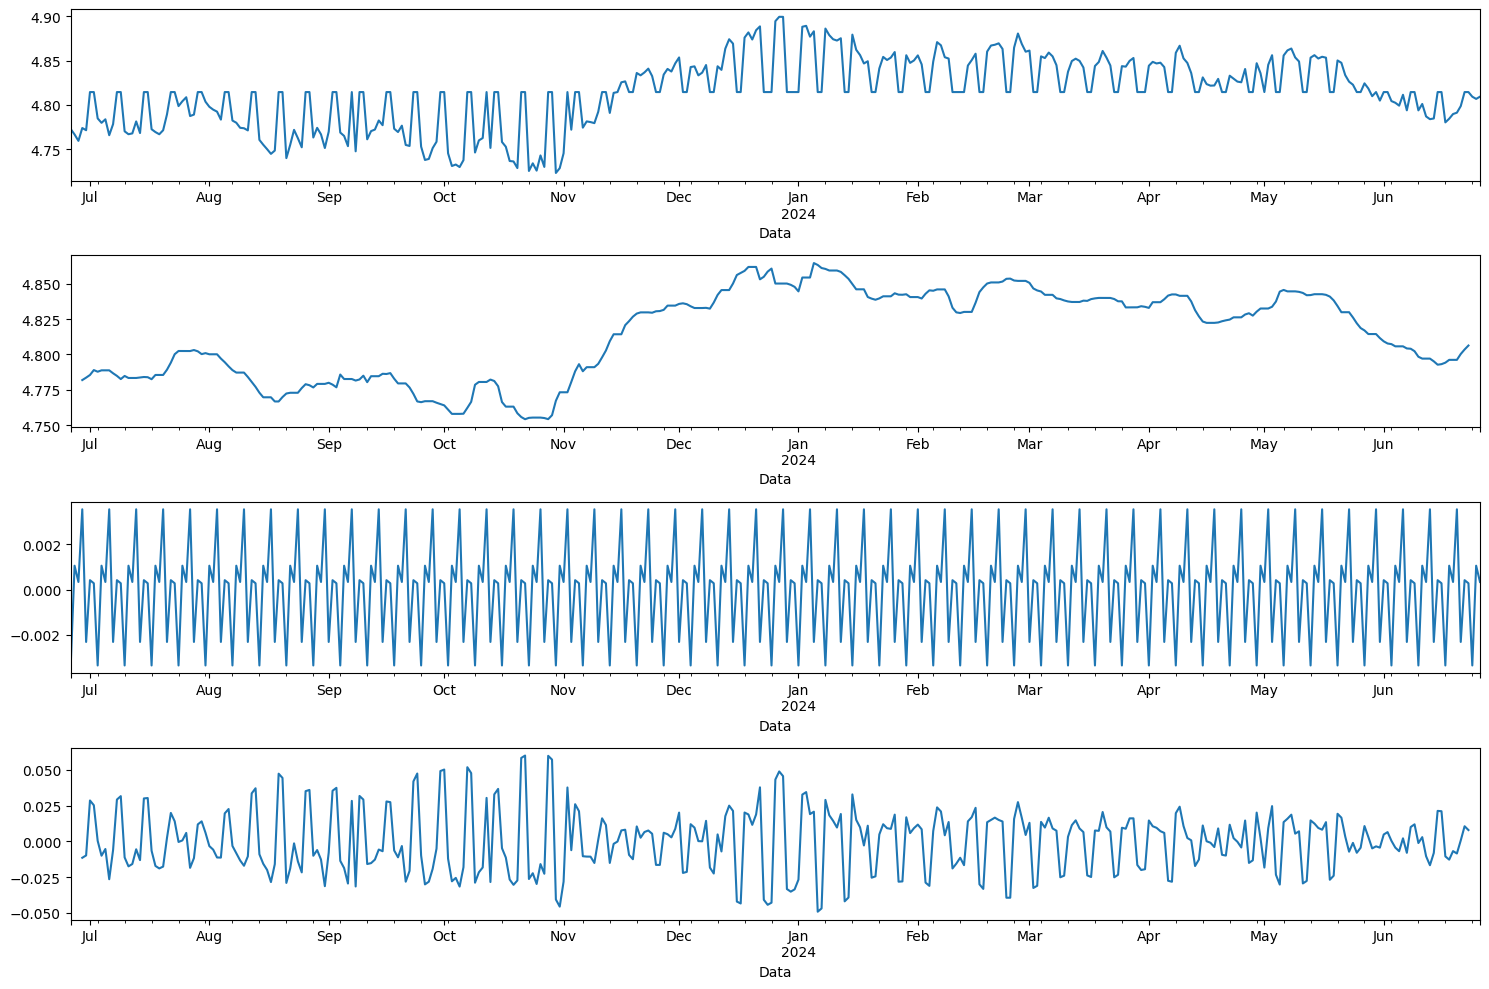

In [7]:
# Decomposição da série temporal
decompose = seasonal_decompose(df_log)

# Plotagem 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

# Plot da série comum
decompose.observed.plot(ax=ax1)
# Plot da tendência
decompose.trend.plot(ax=ax2)
# Plot da sazonalidade
decompose.seasonal.plot(ax=ax3)
#Plot dos ruídos
decompose.resid.plot(ax=ax4)

plt.tight_layout()

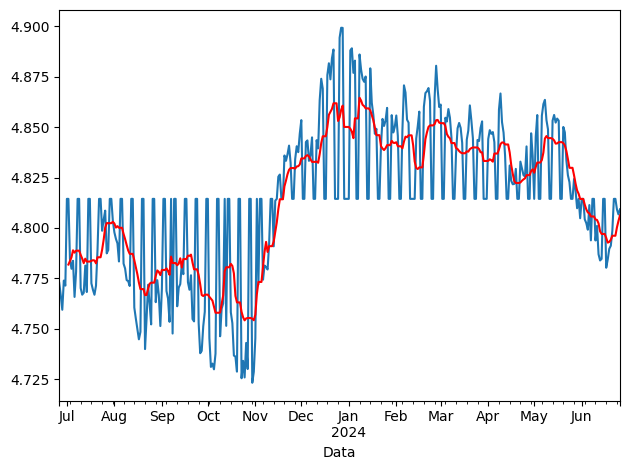

In [8]:
# Analisando a média móvel com uma janela de 7 dias
ma_log = df_log.rolling(7).mean()

f, ax = plt.subplots()
df_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

In [9]:
# Teste Dickey-Fuller pra medir a estacionaridade da série
estacionaridade = adfuller(df_log)

print("Teste ADF")
print(f"Teste Estatístico: {estacionaridade[0]}")
print(f"P-Value: {estacionaridade[1]}")
print("Valores críticos:")

for key, value in estacionaridade[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -1.6286201009600223
P-Value: 0.4682130898686873
Valores críticos:
	1%: -3.4490648539347544
	5%: -2.8697861692116478
	10%: -2.5711631253228306


É perceptível através do gráfico de tendência e do teste Augmented Dickey-Fuller que a série não é estacionária, isso pode afetar diversos modelos, como o ARIMA, que pressupõe que os dados são estacionários.

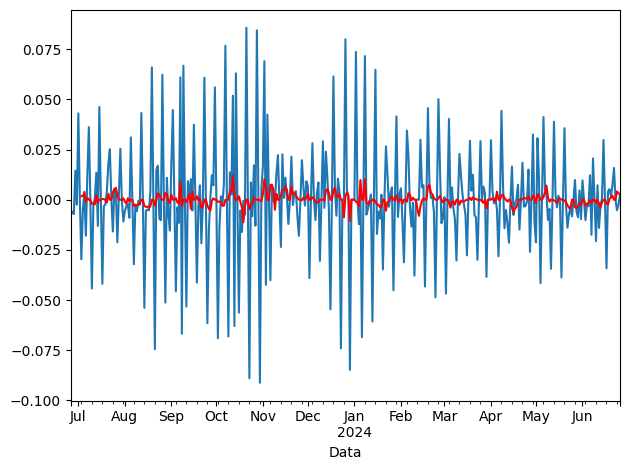

In [10]:
# Derivar a Série Temporal
df_dif = df_log.diff(1)
ma_dif = df_dif.rolling(7).mean()

# Nova Plotagem
f, ax = plt.subplots()
df_dif.plot(ax=ax, legend=False)
ma_dif.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

In [11]:
# Visualizar a série
print(df_dif)

# Retirar os valores NaN do início do DataSet
df_dif = df_dif.dropna()

               Valor
Data                
2023-06-26       NaN
2023-06-27 -0.006108
2023-06-28 -0.007190
2023-06-29  0.014481
2023-06-30 -0.002503
...              ...
2024-06-22  0.015835
2024-06-23  0.000000
2024-06-24 -0.005211
2024-06-25 -0.002498
2024-06-26  0.002531

[367 rows x 1 columns]


In [12]:
estacionaridade = adfuller(df_dif)

print("Teste ADF")
print(f"Teste Estatístico: {estacionaridade[0]}")
print(f"P-Value: {estacionaridade[1]}")
print("Valores críticos:")

for key, value in estacionaridade[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -5.648979734487694
P-Value: 9.961262706212234e-07
Valores críticos:
	1%: -3.4490648539347544
	5%: -2.8697861692116478
	10%: -2.5711631253228306


A Derivação da escala logarítmica foi o suficiente para deixar a série temporal bem mais próximo da estacionaridade segundo o teste Dickey-Fuller

## Métricas

WMAPE (Weighted Mean Absolute Percentage Error) - servirá para medir a precisão de previsões em termos percentuais. Essa métrica é comumente utilizada no ramo financeiro.<br><br>

In [13]:
def wmape(y_true, y_pred):
    
    # Converter para arrays do NumPy para facilitar o cálculo
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Soma dos erros absolutos
    numerador = np.sum(np.abs(y_true - y_pred))

    # soma dos valores reais
    denominador = np.sum(np.abs(y_true))

    #Calculo WMAPE
    valor_wmape = numerador/denominador

    return valor_wmape

R² (Coeficiente de Determinação) - O R² mede a proporção da variabilidade dos dados que é explicada pelo modelo. Em conjunto com o WMAPE, o R² fornece como o modelo se adequa aos dados ao longo do tempo.

In [14]:
from sklearn.metrics import r2_score

## Biblioteca StatsForecast

Inicialmente, será utilizado a biblioteca StatsForecast por pemitir utilizar modelos de maneiras mais automatizadas. Isso possibilita entender como alguns modelos se comportam sem a configuração manual de seus parâmetros.

Essa biblioteca necessita de certas condições para ser utilizada, por isso, primeiro vamos aplicar essas condições no DataFrame

In [15]:
df_forecast = df_dif.reset_index()
df_forecast.rename(columns={'Data':'ds','Valor':'y'}, inplace=True)
df_forecast['unique_id'] = 'Ibovespa'
df_forecast = df_forecast[['unique_id','ds','y']]
df_forecast

unique_id         ds         y
0    Ibovespa 2023-06-27 -0.006108
1    Ibovespa 2023-06-28 -0.007190
2    Ibovespa 2023-06-29  0.014481
3    Ibovespa 2023-06-30 -0.002503
4    Ibovespa 2023-07-01  0.043018
..        ...        ...       ...
361  Ibovespa 2024-06-22  0.015835
362  Ibovespa 2024-06-23  0.000000
363  Ibovespa 2024-06-24 -0.005211
364  Ibovespa 2024-06-25 -0.002498
365  Ibovespa 2024-06-26  0.002531

[366 rows x 3 columns]

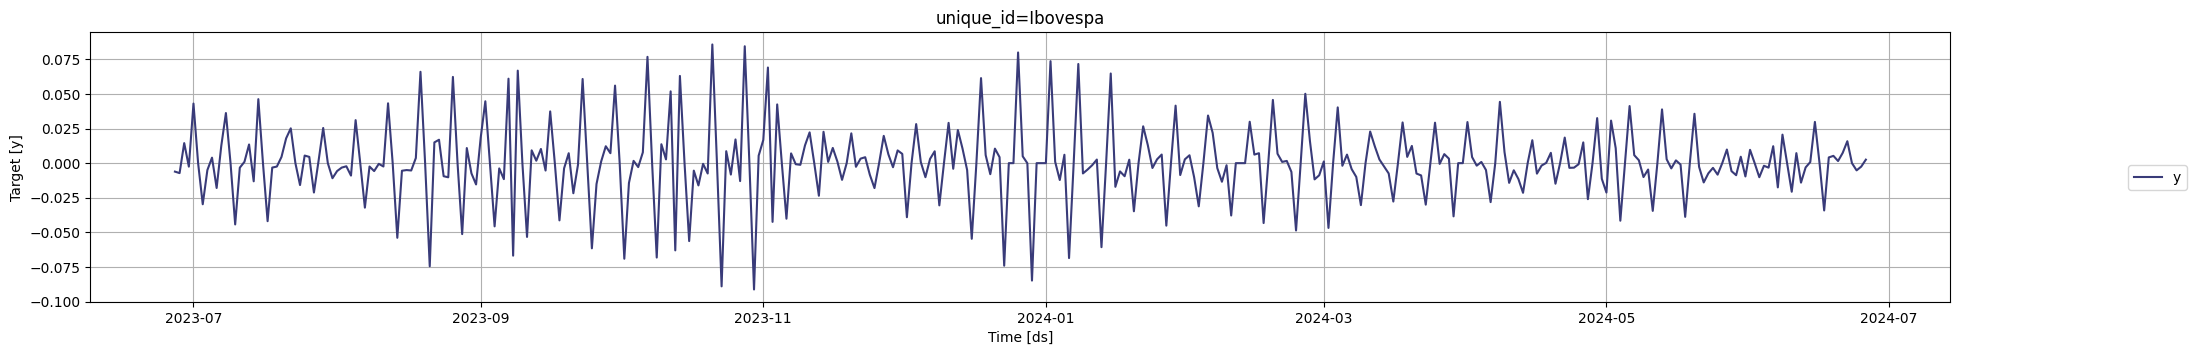

In [16]:
StatsForecast.plot(df_forecast, engine='matplotlib')

Os dados serão divididos em dois outros Dataframes, um para treino dos modelos e outro para comparação, as datas em questão foram escolhidas para que 80% dos dados fossem usados para o treino do modelo

In [17]:
numero = df1.count()
numero

Valor    367
dtype: int64

In [18]:
numero = numero*0.2
numero = int(numero)
numero

73

In [19]:
# Divisão do Dataframe
treino = df_forecast.head(len(df_forecast)-numero)
real = df_forecast.tail(numero)
h = real['ds'].nunique()
h

73

### Naive

Primeiramente vamos utilizar o modelo Naive desta biblioteca. Por ser um modelo mais simplificado, ele servirá como base para comparar performance de modelos mais complexos.

WMAPE: 100.00%
R²: -2e-05


c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


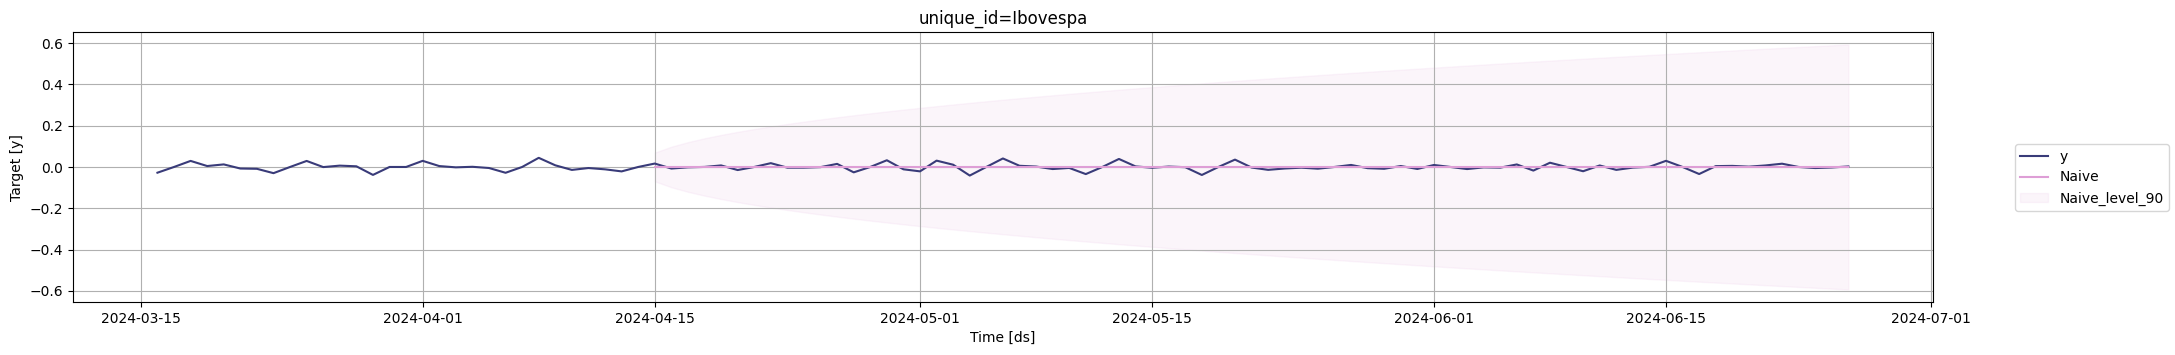

In [20]:
# Criando a função do modelo
sf_N = StatsForecast(models=[Naive()], freq='D', n_jobs=-1)
# Treinamento do modelo
sf_N.fit(treino)

# Previsão
previsao_N = sf_N.predict(h=h, level=[90])
# Adicionando ao DF da predição os valores reais
previsao_N = previsao_N.reset_index().merge(real, on=['ds', 'unique_id'], how='left')

# Calculo do WMAPE
precisao_N = wmape(previsao_N['y'], previsao_N['Naive'])
print(f"WMAPE: {precisao_N:.2%}")

# Calculo do R²
r2_N = r2_score(previsao_N['y'], previsao_N['Naive'])
print(f"R²: {r2_N:.2}")

# Plotagem do comportamento do modelo em comparação a série temporal
sf_N.plot(treino, previsao_N, level=[90], unique_ids=['Ibovespa'],engine ='matplotlib', max_insample_length=30)

O modelo Naive apresentou péssimos resultados, contudo, como dito, ele servirá como base de comparação para modelos mais complexos

In [21]:
previsao_N

unique_id         ds  Naive  Naive-lo-90  Naive-hi-90         y
0   Ibovespa 2024-04-15    0.0    -0.069426     0.069426  0.016542
1   Ibovespa 2024-04-16    0.0    -0.098184     0.098184 -0.007568
2   Ibovespa 2024-04-17    0.0    -0.120250     0.120250 -0.001754
3   Ibovespa 2024-04-18    0.0    -0.138852     0.138852  0.000201
4   Ibovespa 2024-04-19    0.0    -0.155242     0.155242  0.007444
..       ...        ...    ...          ...          ...       ...
68  Ibovespa 2024-06-22    0.0    -0.576698     0.576698  0.015835
69  Ibovespa 2024-06-23    0.0    -0.580862     0.580862  0.000000
70  Ibovespa 2024-06-24    0.0    -0.584996     0.584996 -0.005211
71  Ibovespa 2024-06-25    0.0    -0.589101     0.589101 -0.002498
72  Ibovespa 2024-06-26    0.0    -0.593178     0.593178  0.002531

[73 rows x 6 columns]

### Seasonal Naive

O próximo modelo será o Seasonal Naive. Este modelo funciona de forma semelhante ao Naive, contudo levando em consideração a sazonalidade dos dados. Como a função SeasonalDecompose mostrou que o ciclo de sazonalidade dos dados tem uma duração de 7 dias, esse será o valor utilizado.

WMAPE: 132.17%
R²: -0.81


c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


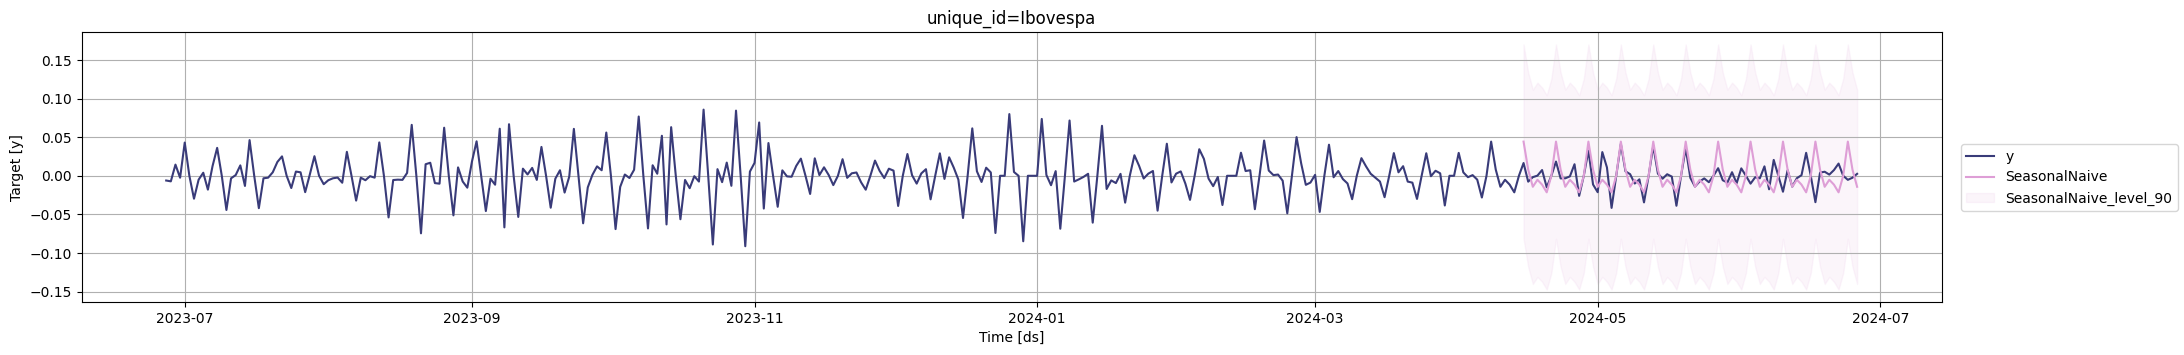

In [22]:
sf_SN = StatsForecast(models=[SeasonalNaive(season_length=7)], freq='D', n_jobs=-1)
sf_SN.fit(treino)

previsao_SN = sf_SN.predict(h=h, level=[90])
previsao_SN = previsao_SN.reset_index().merge(real, on=['ds', 'unique_id'], how='left')

precisao_SN = wmape(previsao_SN['y'].values, previsao_SN['SeasonalNaive'].values)
print(f"WMAPE: {precisao_SN:.2%}")

r2_SN = r2_score(previsao_SN['y'], previsao_SN['SeasonalNaive'])
print(f"R²: {r2_SN:.2}")

sf_SN.plot(treino, previsao_SN, level=[90], unique_ids=['Ibovespa'],engine ='matplotlib')

O modelo se apresentou ineficaz, mostrando resultados das métricas piores que o próprio Naive

In [23]:
previsao_SN

unique_id         ds  SeasonalNaive  SeasonalNaive-lo-90  \
0   Ibovespa 2024-04-15       0.044263            -0.081510   
1   Ibovespa 2024-04-16       0.007985            -0.117788   
2   Ibovespa 2024-04-17      -0.014236            -0.140009   
3   Ibovespa 2024-04-18      -0.005152            -0.130925   
4   Ibovespa 2024-04-19      -0.011447            -0.137220   
..       ...        ...            ...                  ...   
68  Ibovespa 2024-06-22      -0.021413            -0.147186   
69  Ibovespa 2024-06-23       0.000000            -0.125773   
70  Ibovespa 2024-06-24       0.044263            -0.081510   
71  Ibovespa 2024-06-25       0.007985            -0.117788   
72  Ibovespa 2024-06-26      -0.014236            -0.140009   

    SeasonalNaive-hi-90         y  
0              0.170036  0.016542  
1              0.133758 -0.007568  
2              0.111537 -0.001754  
3              0.120621  0.000201  
4              0.114326  0.007444  
..                  ...       ...  
68             0.104360  0.015835  
69             0.125773  0.000000  
70             0.170036 -0.005211  
71             0.133758 -0.002498  
72             0.111537  0.002531  

[73 rows x 6 columns]

### AutoARIMA

c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


WMAPE: 94.32%
R²: 0.15


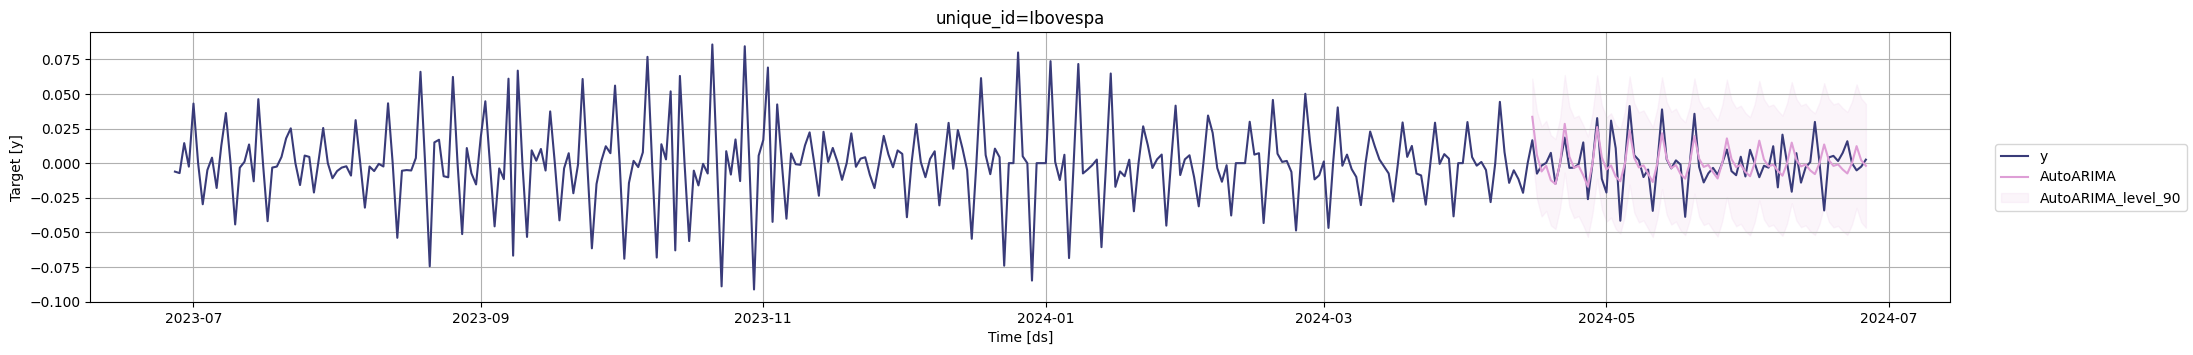

In [24]:
sf_AA = StatsForecast(models=[AutoARIMA(season_length=7, stationary=True,seasonal=True)], freq='D', n_jobs=-1)
sf_AA.fit(treino)

previsao_AA = sf_AA.predict(h=h, level=[90])
previsao_AA = previsao_AA.reset_index().merge(real, on=['ds', 'unique_id'], how='left')

precisao_AA = wmape(previsao_AA['y'].values, previsao_AA['AutoARIMA'].values)
print(f"WMAPE: {precisao_AA:.2%}")

r2_AA = r2_score(previsao_AA['y'], previsao_AA['AutoARIMA'])
print(f"R²: {r2_AA:.2}")

sf_AA.plot(treino, previsao_AA, level=[90], unique_ids=['Ibovespa'],engine ='matplotlib')

o modelo AutoArima não mostrou melhoras na acurácia

In [25]:
previsao_AA

unique_id         ds     AutoARIMA  AutoARIMA-lo-90  AutoARIMA-hi-90  \
0   Ibovespa 2024-04-15  3.344967e-02         0.005851         0.061048   
1   Ibovespa 2024-04-16  5.819002e-03        -0.025716         0.037354   
2   Ibovespa 2024-04-17 -5.996945e-03        -0.038516         0.026523   
3   Ibovespa 2024-04-18 -1.931108e-03        -0.034451         0.030588   
4   Ibovespa 2024-04-19 -1.233762e-02        -0.044857         0.020182   
..       ...        ...           ...              ...              ...   
68  Ibovespa 2024-06-22 -7.456798e-03        -0.051855         0.036941   
69  Ibovespa 2024-06-23 -2.926850e-09        -0.044398         0.044398   
70  Ibovespa 2024-06-24  1.229026e-02        -0.032364         0.056944   
71  Ibovespa 2024-06-25  2.025312e-03        -0.042707         0.046757   
72  Ibovespa 2024-06-26 -1.908067e-03        -0.046661         0.042845   

           y  
0   0.016542  
1  -0.007568  
2  -0.001754  
3   0.000201  
4   0.007444  
..       ...  
68  0.015835  
69  0.000000  
70 -0.005211  
71 -0.002498  
72  0.002531  

[73 rows x 6 columns]

## Biblioteca StatsModels

Será utilizado modelos da biblioteca StatsModels por dois motivos.<br>
<br>
É possível ter mais controle sobre os parâmetros dos modelos<br>
<br>
Não é necessário completar os dados faltantes dos finais de semana, isso possiblita novas interpretações da série temporal. Neste caso serão utilizados as duas versões do dataset para observar o comportamento dos modelos do StatsModels.

In [26]:
# Criando novo DataFrame
df_model = df[['Data','Último']]

# Renomeando a segunda coluna para facilitar os próximos passos
df_model.rename(columns={'Último':'Valor'}, inplace=True)

# Substituindo '.' por '-' na coluna 'Data'
df_model['Data'] = df_model['Data'].str.replace('.', '-')

# Convertendo a coluna 'Data' para datetime e definindo como índice
df_model.index = pd.to_datetime(df_model['Data'], format="%d-%m-%Y")

# Removendo a coluna 'Data'
df_model.drop("Data", inplace=True, axis=1)

# Ordenando o DataFrame por índice em ordem ascendente
df_model.sort_index(ascending=True, inplace=True)

df_model.reset_index(drop=True, inplace=True)

# Transformação logarítmica
df_model = np.log(df_model)

# Diferenciação
df_model = df_model.diff(1)
df_model = df_model.dropna()

df_model

C:\Users\Guilherme\AppData\Local\Temp\ipykernel_9480\3891128137.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.rename(columns={'Último':'Valor'}, inplace=True)
C:\Users\Guilherme\AppData\Local\Temp\ipykernel_9480\3891128137.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_model['Data'] = df_model['Data'].str.replace('.', '-')
C:\Users\Guilherme\AppData\Local\Temp\ipykernel_9480\3891128137.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

Valor
1   -0.006108
2   -0.007190
3    0.014481
4   -0.002503
5    0.013341
..        ...
246  0.001537
247  0.007403
248  0.010624
249 -0.002498
250  0.002531

[250 rows x 1 columns]

In [27]:
df_dif

Valor
Data                
2023-06-27 -0.006108
2023-06-28 -0.007190
2023-06-29  0.014481
2023-06-30 -0.002503
2023-07-01  0.043018
...              ...
2024-06-22  0.015835
2024-06-23  0.000000
2024-06-24 -0.005211
2024-06-25 -0.002498
2024-06-26  0.002531

[366 rows x 1 columns]

### DataFrame sem finais de semana 

In [28]:
numero = int(df_model.count()*0.2)
numero

50

In [29]:
treino = df_model.head(len(df_model)-numero)
real = df_model.tail(numero)

treino.count(), real.count()

(Valor    200
 dtype: int64,
 Valor    50
 dtype: int64)

<Figure size 1000x600 with 0 Axes>

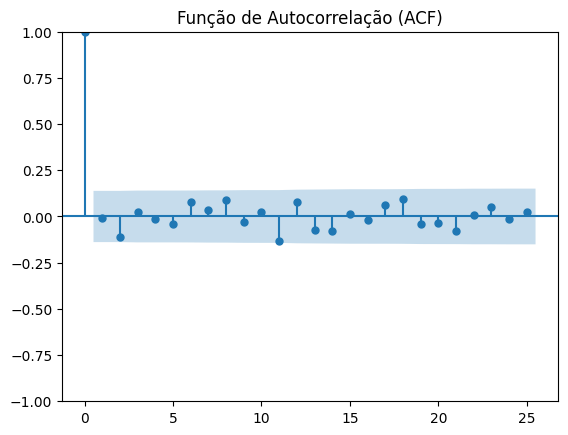

<Figure size 1000x600 with 0 Axes>

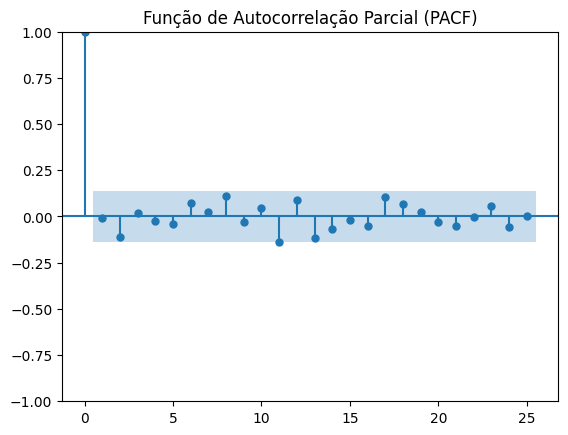

In [30]:
# Plot da Função de Autocorrelação (ACF)
plt.figure(figsize=(10, 6))
plot_acf(treino['Valor'], lags=25)
plt.title('Função de Autocorrelação (ACF)')
plt.show()

# Plot da Função de Autocorrelação Parcial (PACF)
plt.figure(figsize=(10, 6))
plot_pacf(treino['Valor'], lags=25)
plt.title('Função de Autocorrelação Parcial (PACF)')
plt.show()

O lags não apresentam valores que cortam o intervalo de confiança, logo não são considerados estatisticamente significativos

#### Modelo ARIMA

In [31]:
# Criando a função do modelo
sm_ARIMA = ARIMA(treino['Valor'], order=(11, 1, 11))
# Treinando o modelo
sm_ARIMA_fit = sm_ARIMA.fit()

# Fazer previsões
forecast_steps = 51  # Número de pontos a serem previstos
forecast = sm_ARIMA_fit.forecast(steps=forecast_steps)
real['Previsto'] = forecast
real

c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Guilhe

Valor  Previsto
201 -0.007568 -0.001127
202 -0.001754 -0.001261
203  0.000201 -0.006905
204  0.007444 -0.004652
205  0.003582 -0.000335
206 -0.003390  0.004506
207 -0.003257  0.002824
208 -0.000762 -0.001932
209  0.014970 -0.003298
210  0.006507 -0.002468
211 -0.011276  0.001236
212  0.009469  0.003483
213  0.010852  0.000327
214 -0.000335 -0.003481
215  0.005775 -0.004621
216  0.002095 -0.002462
217 -0.010036  0.002487
218 -0.004598  0.004067
219  0.004340  0.000708
220  0.002805 -0.002775
221 -0.003797 -0.004278
222  0.001998 -0.002043
223 -0.001037  0.002245
224 -0.003126  0.002707
225 -0.002657 -0.000279
226 -0.013926 -0.003162
227 -0.007357 -0.003951
228 -0.003397 -0.000750
229  0.001527  0.002950
230 -0.005768  0.002508
231 -0.008706 -0.000531
232 -0.004975 -0.003575
233 -0.000541 -0.003934
234 -0.001887 -0.000339
235 -0.003248  0.002672
236  0.012214  0.002000
237 -0.017500 -0.000809
238 -0.000058 -0.003616
239  0.007220 -0.003189
240 -0.014066  0.000418
241 -0.003073  0.002578
242  0.000786  0.001575
243 -0.004389 -0.001392
244  0.004121 -0.003896
245  0.005261 -0.002687
246  0.001537  0.000799
247  0.007403  0.002480
248  0.010624  0.001329
249 -0.002498 -0.001767
250  0.002531 -0.003778

In [32]:
a = real['Valor'].sum()
b = real['Previsto'].sum()
print(a)
print(b)

c = b - a
c

-0.021720785379748975
-0.035393537264247106


-0.013672751884498131

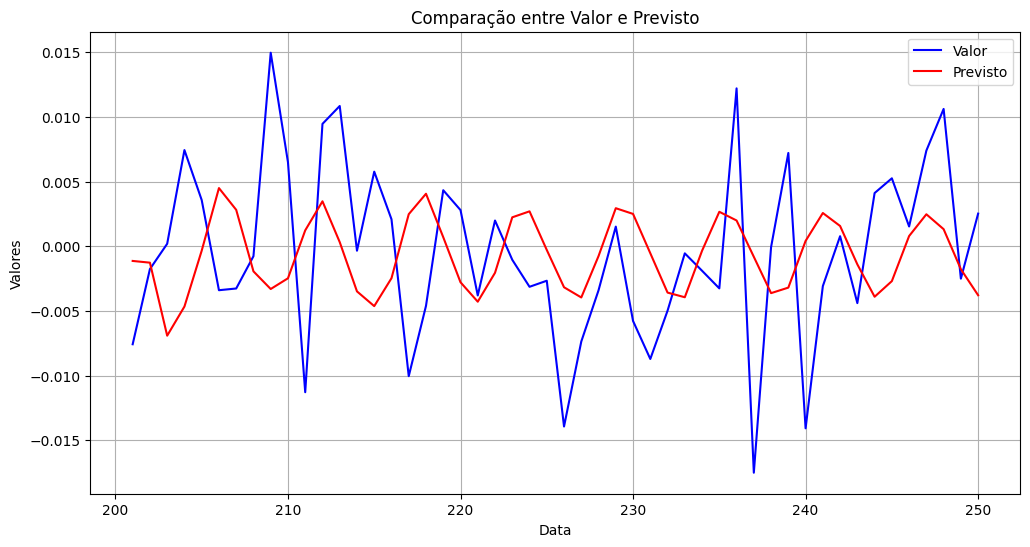

In [33]:
# Plotar as duas séries temporais
plt.figure(figsize=(12, 6))
plt.plot(real.index, real['Valor'], label='Valor', color='blue')
plt.plot(real.index, real['Previsto'], label='Previsto', color='red')
plt.title('Comparação entre Valor e Previsto')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
# Calculo do WMAPE
precisao_sm_ARIMA_s = wmape(real['Valor'], real['Previsto'])
print(f"WMAPE: {precisao_sm_ARIMA_s:.2%}")

# Calculo do R²
r2_sm_ARIMA_s = r2_score(real['Valor'], real['Previsto'])
print(f"R²: {r2_sm_ARIMA_s:.2}")

WMAPE: 117.69%
R²: -0.25


#### Modelo SARIMA

In [35]:
# Criando a função do modelo
sm_SARIMA = SARIMAX(treino['Valor'], order=(6, 1, 6), 
                                   seasonal_order=(6,1,6,14),
                                   enforce_stationarity=False,
                                   enforce_invertibility=False)
# Treinando o modelo
sm_SARIMA_fit = sm_SARIMA.fit()

# Fazer previsões
forecast_steps = 51  # Número de pontos a serem previstos
forecast = sm_SARIMA_fit.forecast(steps=forecast_steps)
real['Previsto'] = forecast
real

c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

Valor  Previsto
201 -0.007568 -0.001073
202 -0.001754 -0.004833
203  0.000201 -0.004282
204  0.007444  0.001426
205  0.003582  0.000365
206 -0.003390 -0.001610
207 -0.003257 -0.003894
208 -0.000762 -0.000519
209  0.014970 -0.000465
210  0.006507 -0.000730
211 -0.011276 -0.003927
212  0.009469 -0.007467
213  0.010852 -0.001596
214 -0.000335 -0.001035
215  0.005775  0.003822
216  0.002095  0.000020
217 -0.010036 -0.007452
218 -0.004598  0.001482
219  0.004340 -0.001499
220  0.002805 -0.001576
221 -0.003797 -0.004323
222  0.001998  0.004938
223 -0.001037  0.005314
224 -0.003126 -0.005979
225 -0.002657 -0.006287
226 -0.013926 -0.009238
227 -0.007357 -0.004716
228 -0.003397 -0.000057
229  0.001527  0.001986
230 -0.005768 -0.001958
231 -0.008706 -0.005580
232 -0.004975 -0.000214
233 -0.000541 -0.001822
234 -0.001887 -0.002939
235 -0.003248 -0.003207
236  0.012214  0.000977
237 -0.017500 -0.001270
238 -0.000058 -0.006375
239  0.007220 -0.004260
240 -0.014066 -0.009290
241 -0.003073 -0.002395
242  0.000786 -0.001270
243 -0.004389  0.000807
244  0.004121 -0.002575
245  0.005261 -0.007528
246  0.001537 -0.000177
247  0.007403 -0.001789
248  0.010624 -0.002450
249 -0.002498 -0.005743
250  0.002531  0.000577

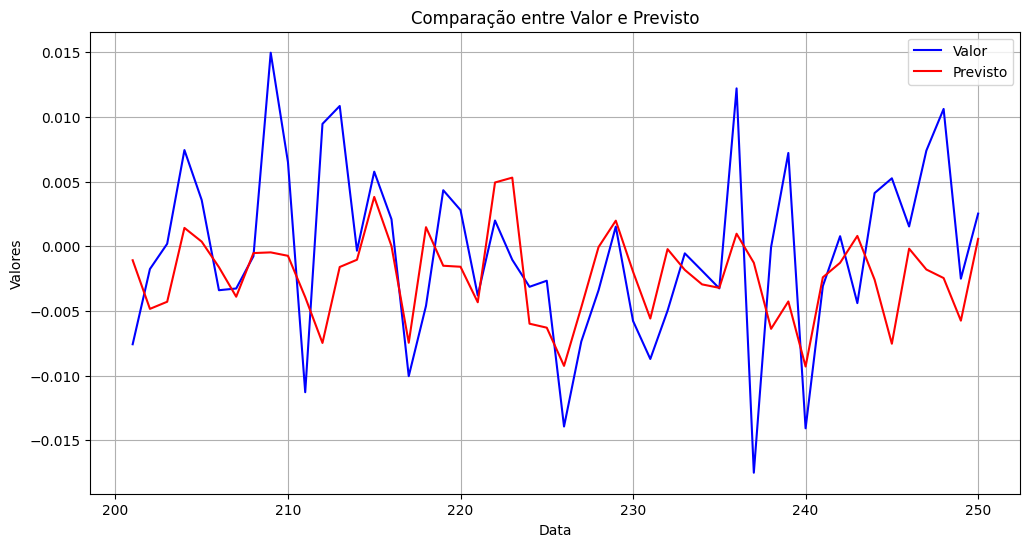

In [36]:
# Plotar as duas séries temporais
plt.figure(figsize=(12, 6))
plt.plot(real.index, real['Valor'], label='Valor', color='blue')
plt.plot(real.index, real['Previsto'], label='Previsto', color='red')
plt.title('Comparação entre Valor e Previsto')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
# Calculo do WMAPE
precisao_sm_SARIMA_s = wmape(real['Valor'], real['Previsto'])
print(f"WMAPE: {precisao_sm_SARIMA_s:.2%}")

# Calculo do R²
r2_sm_SARIMA_s = r2_score(real['Valor'], real['Previsto'])
print(f"R²: {r2_sm_SARIMA_s:.2}")

WMAPE: 95.85%
R²: 0.028


### DataFrame com finais de semana 

In [38]:
df_dif

Valor
Data                
2023-06-27 -0.006108
2023-06-28 -0.007190
2023-06-29  0.014481
2023-06-30 -0.002503
2023-07-01  0.043018
...              ...
2024-06-22  0.015835
2024-06-23  0.000000
2024-06-24 -0.005211
2024-06-25 -0.002498
2024-06-26  0.002531

[366 rows x 1 columns]

In [39]:
numero = int(df_dif.count()*0.2)
numero

73

In [40]:
treino = df_dif.head(len(df_dif)-numero)
real = df_dif.tail(numero)

treino.count(), real.count()

(Valor    293
 dtype: int64,
 Valor    73
 dtype: int64)

<Figure size 1000x600 with 0 Axes>

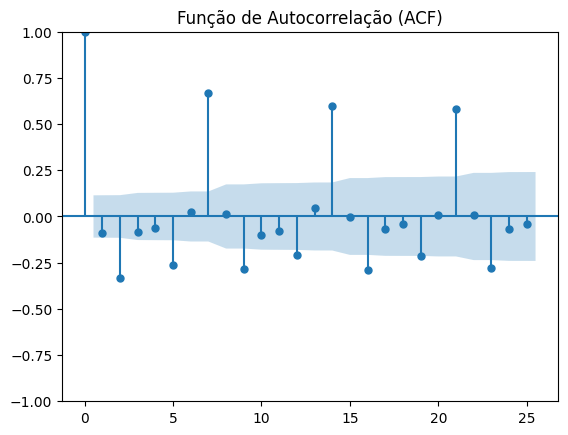

<Figure size 1000x600 with 0 Axes>

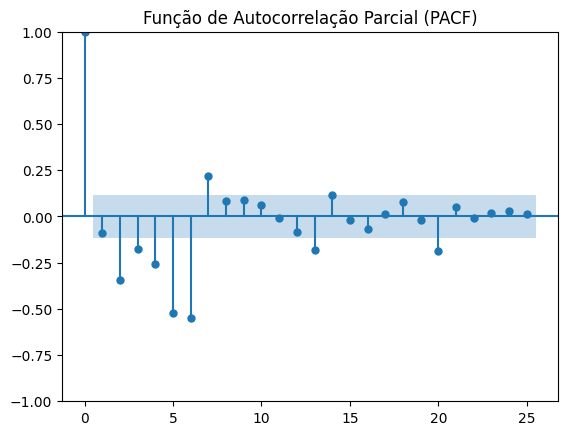

In [41]:
# Plot da Função de Autocorrelação (ACF)
plt.figure(figsize=(10, 6))
plot_acf(treino['Valor'], lags=25)
plt.title('Função de Autocorrelação (ACF)')
plt.show()

# Plot da Função de Autocorrelação Parcial (PACF)
plt.figure(figsize=(10, 6))
plot_pacf(treino['Valor'], lags=25)
plt.title('Função de Autocorrelação Parcial (PACF)')
plt.show()

#### Modelo ARIMA

In [42]:
# Criando a função do modelo
sm_ARIMA = ARIMA(treino['Valor'], order=(20, 1, 21))
# Treinando o modelo
sm_ARIMA_fit = sm_ARIMA.fit()

# Fazer previsões
forecast_steps = 73  # Número de pontos a serem previstos
forecast = sm_ARIMA_fit.forecast(steps=forecast_steps)
real['Previsto'] = forecast
real

c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Guilherme\AppData\Local\Temp\ipykernel_9480\1617349849.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

Valor  Previsto
Data                          
2024-04-15  0.016542  0.035758
2024-04-16 -0.007568  0.005474
2024-04-17 -0.001754 -0.007023
2024-04-18  0.000201 -0.004651
2024-04-19  0.007444 -0.018174
...              ...       ...
2024-06-22  0.015835 -0.002457
2024-06-23  0.000000  0.003644
2024-06-24 -0.005211  0.008962
2024-06-25 -0.002498  0.000337
2024-06-26  0.002531 -0.006650

[73 rows x 2 columns]

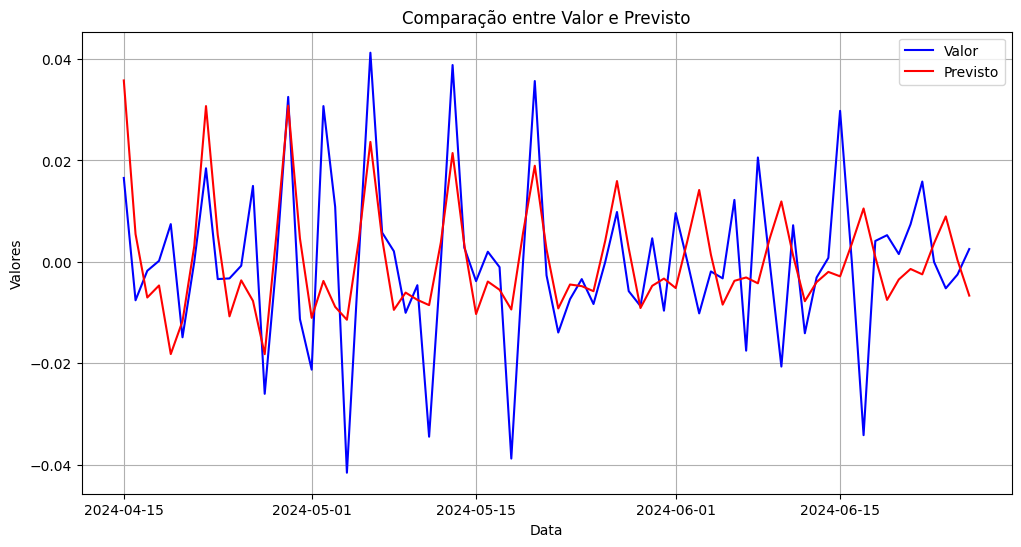

In [44]:
# Plotar as duas séries temporais
plt.figure(figsize=(12, 6))
plt.plot(real.index, real['Valor'], label='Valor', color='blue')
plt.plot(real.index, real['Previsto'], label='Previsto', color='red')
plt.title('Comparação entre Valor e Previsto')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
# Calculo do WMAPE
precisao_sm_ARIMA_c = wmape(real['Valor'], real['Previsto'])
print(f"WMAPE: {precisao_sm_ARIMA_c:.2%}")

# Calculo do R²
r2_sm_ARIMA_c = r2_score(real['Valor'], real['Previsto'])
print(f"R²: {r2_sm_ARIMA_c:.2}")

WMAPE: 99.18%
R²: 0.18


Modelo SARIMA

In [46]:
# Criando a função do modelo
sm_SARIMA = SARIMAX(treino['Valor'], order=(0, 1, 2),
                                     seasonal_order=(2,1,2,7),
                                     enforce_stationarity=False,
                                     enforce_invertibility=False)
# Treinando o modelo
sm_SARIMA_fit = sm_SARIMA.fit()

# Fazer previsões
forecast_steps = 73  # Número de pontos a serem previstos
forecast = sm_SARIMA_fit.forecast(steps=forecast_steps)
real['Previsto'] = forecast
real

c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Guilherme\AppData\Local\Temp\ipykernel_9480\3720412458.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real['Previsto'] = forecast


Valor  Previsto
Data                          
2024-04-15  0.016542  0.037750
2024-04-16 -0.007568  0.005351
2024-04-17 -0.001754 -0.005759
2024-04-18  0.000201 -0.001816
2024-04-19  0.007444 -0.017760
...              ...       ...
2024-06-22  0.015835 -0.019939
2024-06-23  0.000000  0.000006
2024-06-24 -0.005211  0.037483
2024-06-25 -0.002498  0.005645
2024-06-26  0.002531 -0.006249

[73 rows x 2 columns]

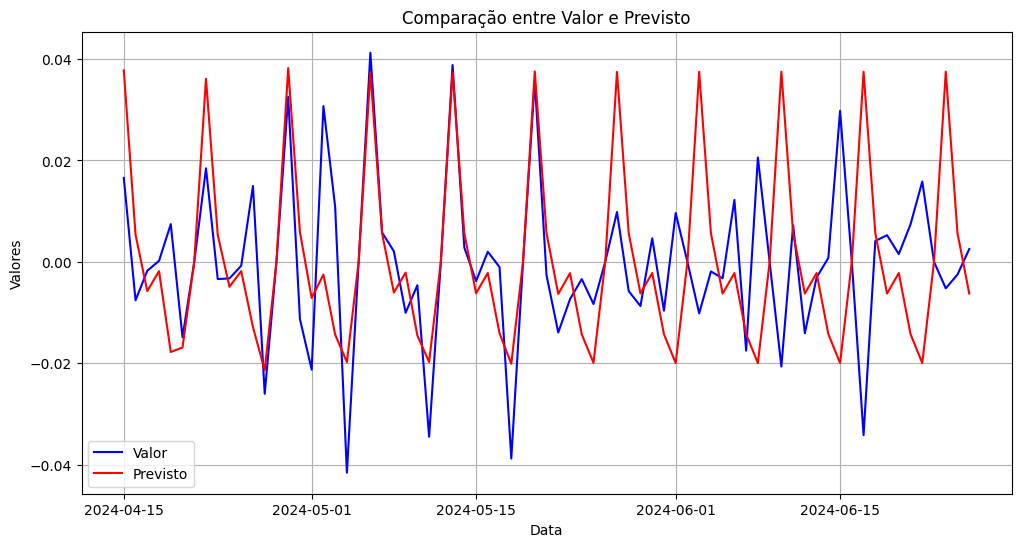

In [47]:
# Plotar as duas séries temporais
plt.figure(figsize=(12, 6))
plt.plot(real.index, real['Valor'], label='Valor', color='blue')
plt.plot(real.index, real['Previsto'], label='Previsto', color='red')
plt.title('Comparação entre Valor e Previsto')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
# Calculo do WMAPE
precisao_sm_SARIMA_c = wmape(real['Valor'], real['Previsto'])
print(f"WMAPE: {precisao_sm_SARIMA_c:.2%}")

# Calculo do R²
r2_sm_SARIMA_c = r2_score(real['Valor'], real['Previsto'])
print(f"R²: {r2_sm_SARIMA_c:.2}")

WMAPE: 116.29%
R²: -0.5


## Biblioteca Prophet

A biblioteca Prophet será utilizada para comparação em relação aos modelos das outras bibliotecas

### Preparação do DataSet

Por precisar de uma coluna específica para passagem de tempo, vamos utilizar apenas a versão df_dif do DataSet

In [52]:
df_ph = df_dif
df_ph

Valor
Data                
2023-06-27 -0.006108
2023-06-28 -0.007190
2023-06-29  0.014481
2023-06-30 -0.002503
2023-07-01  0.043018
...              ...
2024-06-22  0.015835
2024-06-23  0.000000
2024-06-24 -0.005211
2024-06-25 -0.002498
2024-06-26  0.002531

[366 rows x 1 columns]

In [53]:
df_ph.reset_index(inplace=True)
df_ph.rename(columns={'Valor':'y','Data':'ds'}, inplace=True)
df_ph

ds         y
0   2023-06-27 -0.006108
1   2023-06-28 -0.007190
2   2023-06-29  0.014481
3   2023-06-30 -0.002503
4   2023-07-01  0.043018
..         ...       ...
361 2024-06-22  0.015835
362 2024-06-23  0.000000
363 2024-06-24 -0.005211
364 2024-06-25 -0.002498
365 2024-06-26  0.002531

[366 rows x 2 columns]

In [54]:
treino = df_ph.head(len(df_ph)-numero)
real = df_ph.tail(numero)

treino.count(), real.count()

(ds    293
 y     293
 dtype: int64,
 ds    73
 y     73
 dtype: int64)

In [55]:
# Criando a função do modelo
ph = Prophet()
# Treinando o modelo
ph.fit(treino)
# Criando DataSet das predições
futuro = ph.make_future_dataframe(periods=73)
futuro

# Fazendo as Predições
forecast_ph = ph.predict(futuro)
forecast_ph[['ds','yhat','yhat_lower','yhat_upper']].tail(73)

13:49:07 - cmdstanpy - INFO - Chain [1] start processing
13:49:08 - cmdstanpy - INFO - Chain [1] done processing


ds      yhat  yhat_lower  yhat_upper
293 2024-04-15 -0.007241   -0.045461    0.030487
294 2024-04-16  0.005362   -0.031255    0.040005
295 2024-04-17  0.000389   -0.035902    0.034809
296 2024-04-18  0.003619   -0.032290    0.040985
297 2024-04-19 -0.007050   -0.044913    0.030174
..         ...       ...         ...         ...
361 2024-06-22  0.005545   -0.028468    0.041253
362 2024-06-23  0.000129   -0.035119    0.037915
363 2024-06-24 -0.007028   -0.045578    0.027339
364 2024-06-25  0.005575   -0.031476    0.043578
365 2024-06-26  0.000602   -0.034274    0.036939

[73 rows x 4 columns]

In [56]:
real['y_previsto'] = forecast_ph[['yhat']].tail(73)
real

C:\Users\Guilherme\AppData\Local\Temp\ipykernel_9480\556501494.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real['y_previsto'] = forecast_ph[['yhat']].tail(73)


ds         y  y_previsto
293 2024-04-15  0.016542   -0.007241
294 2024-04-16 -0.007568    0.005362
295 2024-04-17 -0.001754    0.000389
296 2024-04-18  0.000201    0.003619
297 2024-04-19  0.007444   -0.007050
..         ...       ...         ...
361 2024-06-22  0.015835    0.005545
362 2024-06-23  0.000000    0.000129
363 2024-06-24 -0.005211   -0.007028
364 2024-06-25 -0.002498    0.005575
365 2024-06-26  0.002531    0.000602

[73 rows x 3 columns]

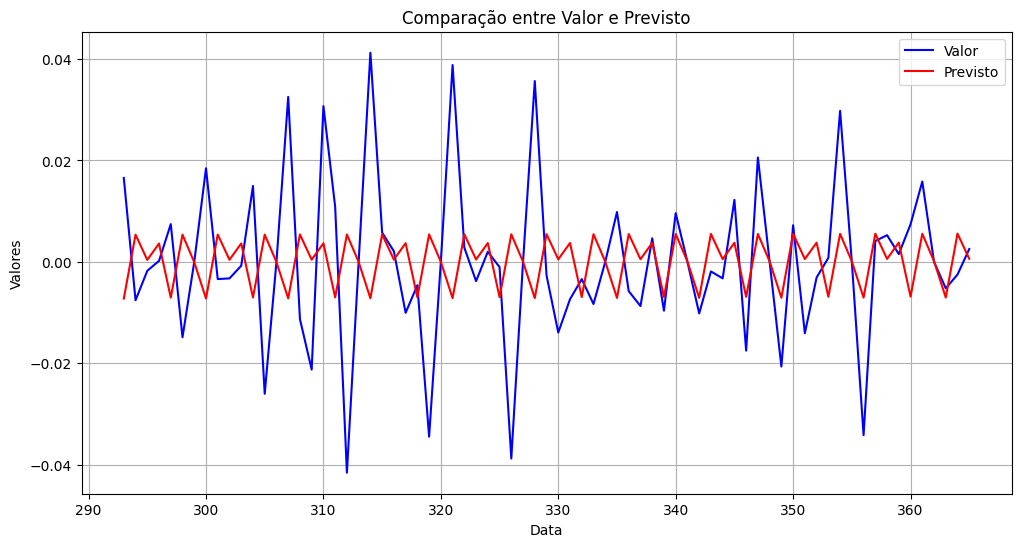

In [57]:
# Plotar as duas séries temporais
plt.figure(figsize=(12, 6))
plt.plot(real.index, real['y'], label='Valor', color='blue')
plt.plot(real.index, real['y_previsto'], label='Previsto', color='red')
plt.title('Comparação entre Valor e Previsto')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)
plt.show()

In [58]:
# Calculo do WMAPE
precisao_prophet = wmape(real['y'], real['y_previsto'])
print(f"WMAPE: {precisao_prophet:.2%}")

# Calculo do R²
r2_prophet = r2_score(real['y'], real['y_previsto'])
print(f"R²: {r2_prophet:.2}")

WMAPE: 111.97%
R²: -0.25


In [59]:
print('RESUMO DOS MODELOS:')
print(f'Modelo Naive:\n WMAPE: {precisao_N:.2%} \n R²: {r2_N:.2} \n')
print(f'Modelo SeasonalNaive:\n WMAPE: {precisao_SN:.2%} \n R²: {r2_SN:.2} \n')
print(f'Modelo AutoARIMA:\n WMAPE: {precisao_AA:.2%} \n R²: {r2_AA:.2} \n')
print(f'Modelo ARIMA sem complementação:\n WMAPE: {precisao_sm_ARIMA_s:.2%} \n R²: {r2_sm_ARIMA_s:.2} \n')
print(f'Modelo ARIMA com complementação:\n WMAPE: {precisao_sm_ARIMA_c:.2%} \n R²: {r2_sm_ARIMA_c:.2} \n')
print(f'Modelo SARIMA sem complementação:\n WMAPE: {precisao_sm_SARIMA_s:.2%} \n R²: {r2_sm_SARIMA_s:.2} \n')
print(f'Modelo SARIMA com complementação:\n WMAPE: {precisao_sm_SARIMA_c:.2%} \n R²: {r2_sm_SARIMA_c:.2} \n')
print(f'Modelo Prophet:\n WMAPE: {precisao_prophet:.2%} \n R²: {r2_prophet:.2} \n')


RESUMO DOS MODELOS:
Modelo Naive:
 WMAPE: 100.00% 
 R²: -2e-05 

Modelo SeasonalNaive:
 WMAPE: 132.17% 
 R²: -0.81 

Modelo AutoARIMA:
 WMAPE: 94.32% 
 R²: 0.15 

Modelo ARIMA sem complementação:
 WMAPE: 117.69% 
 R²: -0.25 

Modelo ARIMA com complementação:
 WMAPE: 99.18% 
 R²: 0.18 

Modelo SARIMA sem complementação:
 WMAPE: 95.85% 
 R²: 0.028 

Modelo SARIMA com complementação:
 WMAPE: 116.29% 
 R²: -0.5 

Modelo Prophet:
 WMAPE: 111.97% 
 R²: -0.25 



Os modelos responderam muito abaixo do esperado. Uma possibilidade é pela falta de dados. Por isso, os modelos autoARIMA, ARIMA, SARIMA e Prophet serão refeitos utilizando dados referentes a dois anos

## Utilizando Dados referentes a 2 anos

In [60]:
# Carregar o DataFrame
df2 = pd.read_csv('Ibovespa 2.csv')

# Criando novo DataFrame
df2 = df2[['Data','Último']]

# Renomeando a segunda coluna para facilitar os próximos passos
df2.rename(columns={'Último':'Valor'}, inplace=True)

# Substituindo '.' por '-' na coluna 'Data'
df2['Data'] = df2['Data'].str.replace('.', '-')

# Convertendo a coluna 'Data' para datetime e definindo como índice
df2.index = pd.to_datetime(df2['Data'], format="%d-%m-%Y")

# Removendo a coluna 'Data'
df2.drop("Data", inplace=True, axis=1)

# Ordenando o DataFrame por índice em ordem ascendente
df2.sort_index(ascending=True, inplace=True)

df2

C:\Users\Guilherme\AppData\Local\Temp\ipykernel_9480\961824084.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df2['Data'] = df2['Data'].str.replace('.', '-')


Valor
Data               
2022-06-27  100.764
2022-06-28  100.591
2022-06-29   99.622
2022-06-30   98.542
2022-07-01   98.954
...             ...
2024-06-20  120.446
2024-06-21  121.341
2024-06-24  122.637
2024-06-25  122.331
2024-06-26  122.641

[500 rows x 1 columns]

In [61]:
# Indicando que a frequência do DataFrame é por dia
df2_freq = df2.asfreq('D')

# Printar o DataFrame antes da tranformação
print(df2_freq.tail(10),'\n\n')

df2_media = df2.mean()
df2_freq = df2_freq.fillna(df2_media)

print(df2_freq.tail(10),'\n\n')

              Valor
Data               
2024-06-17  119.138
2024-06-18  119.630
2024-06-19  120.261
2024-06-20  120.446
2024-06-21  121.341
2024-06-22      NaN
2024-06-23      NaN
2024-06-24  122.637
2024-06-25  122.331
2024-06-26  122.641 


                 Valor
Data                  
2024-06-17  119.138000
2024-06-18  119.630000
2024-06-19  120.261000
2024-06-20  120.446000
2024-06-21  121.341000
2024-06-22  115.904046
2024-06-23  115.904046
2024-06-24  122.637000
2024-06-25  122.331000
2024-06-26  122.641000 




In [62]:
# Transformação logarítmica
df2_log = np.log(df2_freq)
df2_log

Valor
Data                
2022-06-27  4.612781
2022-06-28  4.611063
2022-06-29  4.601383
2022-06-30  4.590483
2022-07-01  4.594655
...              ...
2024-06-22  4.752763
2024-06-23  4.752763
2024-06-24  4.809229
2024-06-25  4.806730
2024-06-26  4.809261

[731 rows x 1 columns]

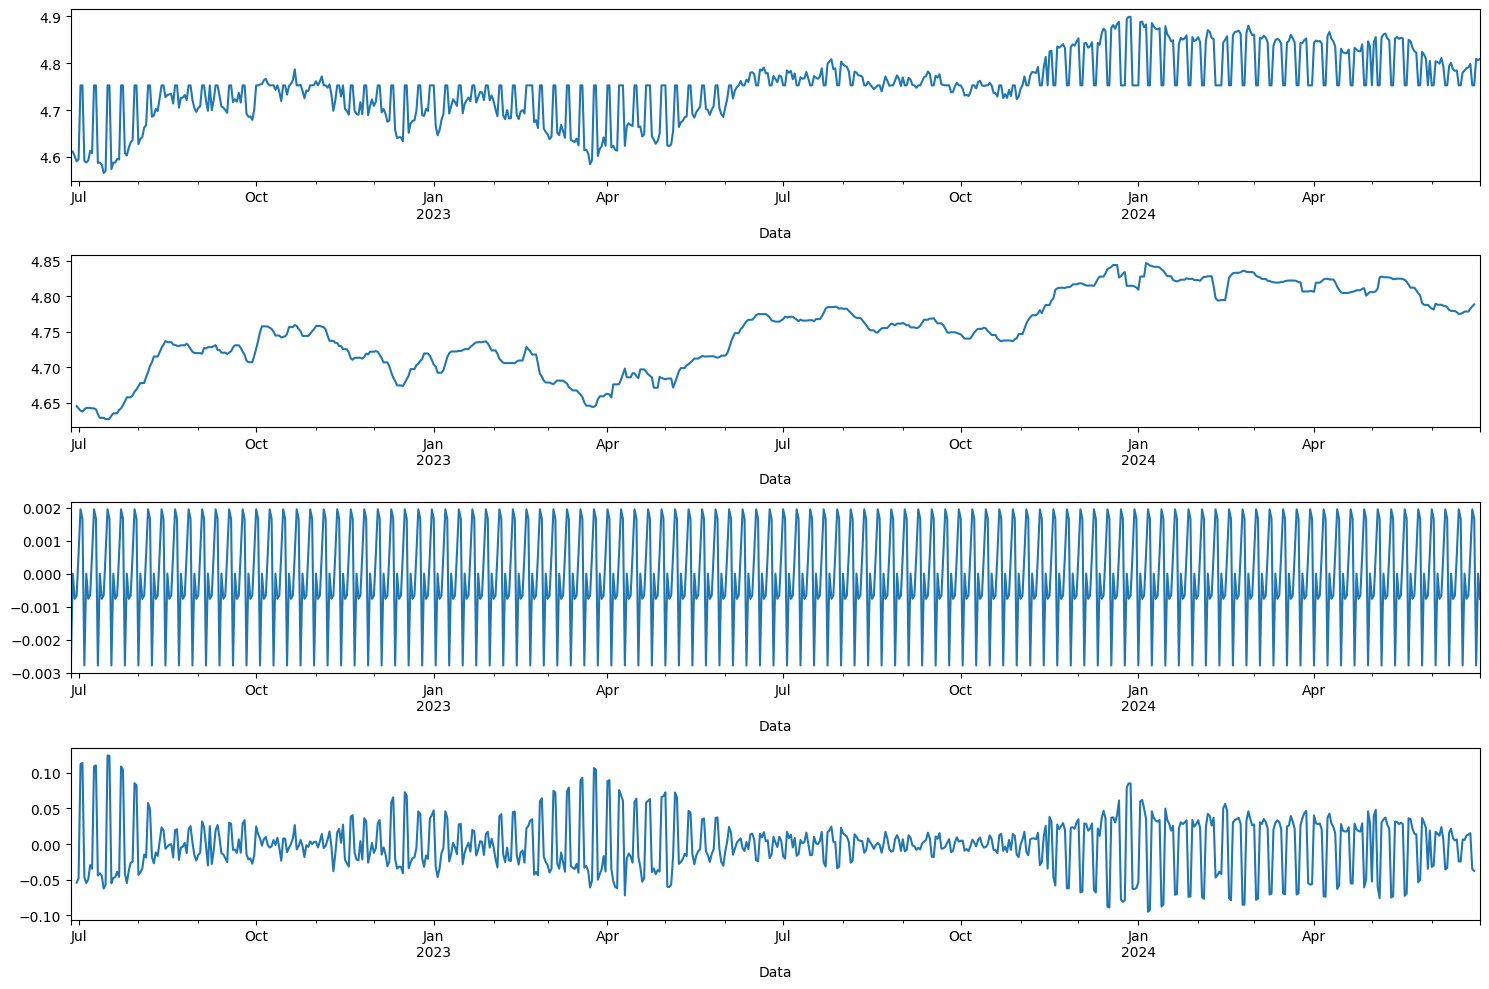

In [63]:
# Decomposição da série temporal
decompose = seasonal_decompose(df2_log)

# Plotagem 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

# Plot da série comum
decompose.observed.plot(ax=ax1)
# Plot da tendência
decompose.trend.plot(ax=ax2)
# Plot da sazonalidade
decompose.seasonal.plot(ax=ax3)
#Plot dos ruídos
decompose.resid.plot(ax=ax4)

plt.tight_layout()

In [64]:
# Teste Dickey-Fuller pra medir a estacionaridade da série
estacionaridade = adfuller(df2_log)

print("Teste ADF")
print(f"Teste Estatístico: {estacionaridade[0]}")
print(f"P-Value: {estacionaridade[1]}")
print("Valores críticos:")

for key, value in estacionaridade[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -2.0957030425001766
P-Value: 0.2462459365246295
Valores críticos:
	1%: -3.439516060164992
	5%: -2.8655850998755263
	10%: -2.5689240826597173


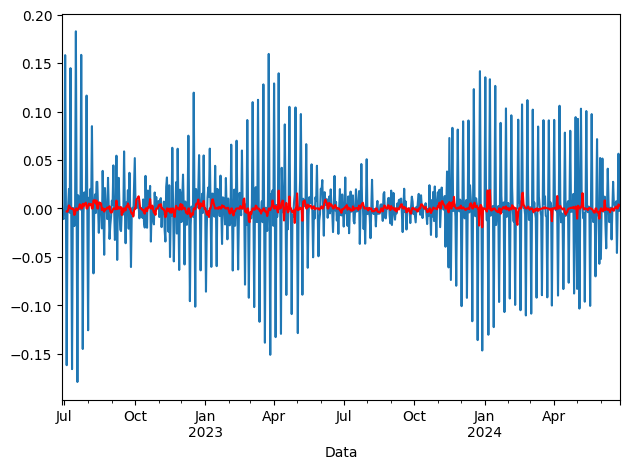

In [65]:
# Derivar a Série Temporal
df2_dif = df2_log.diff(1)
df2_dif = df2_dif.dropna()
ma2_dif = df2_dif.rolling(7).mean()

# Nova Plotagem
f, ax = plt.subplots()
df2_dif.plot(ax=ax, legend=False)
ma2_dif.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

In [66]:
estacionaridade = adfuller(df2_dif)

print("Teste ADF")
print(f"Teste Estatístico: {estacionaridade[0]}")
print(f"P-Value: {estacionaridade[1]}")
print("Valores críticos:")

for key, value in estacionaridade[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -6.896648137789238
P-Value: 1.3136882453599778e-09
Valores críticos:
	1%: -3.439606888036868
	5%: -2.865625121924057
	10%: -2.5689454046801052


### AutoARIMA

In [67]:
df2_forecast = df2_dif.reset_index()
df2_forecast.rename(columns={'Data':'ds','Valor':'y'}, inplace=True)
df2_forecast['unique_id'] = 'Ibovespa'
df2_forecast = df2_forecast[['unique_id','ds','y']]
df2_forecast

unique_id         ds         y
0    Ibovespa 2022-06-28 -0.001718
1    Ibovespa 2022-06-29 -0.009680
2    Ibovespa 2022-06-30 -0.010900
3    Ibovespa 2022-07-01  0.004172
4    Ibovespa 2022-07-02  0.158108
..        ...        ...       ...
725  Ibovespa 2024-06-22 -0.045842
726  Ibovespa 2024-06-23  0.000000
727  Ibovespa 2024-06-24  0.056466
728  Ibovespa 2024-06-25 -0.002498
729  Ibovespa 2024-06-26  0.002531

[730 rows x 3 columns]

In [68]:
# Divisão do Dataframe
numero = df2_forecast['y'].count()
numero = numero*0.1
numero = int(numero)

treino = df2_forecast.head(len(df2_forecast)-numero)
real = df2_forecast.tail(numero)
h = real['ds'].nunique()
h

73

c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


WMAPE: 47.83%
R²: 0.75


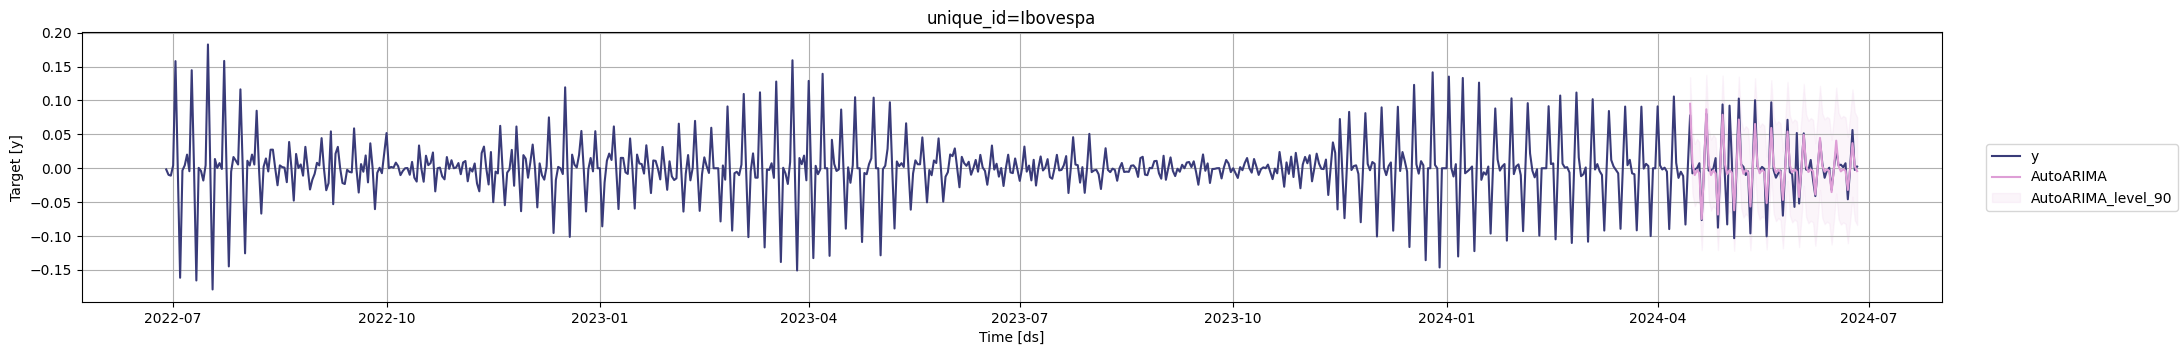

In [69]:
sf_AA = StatsForecast(models=[AutoARIMA(season_length=7, stationary=True,seasonal=True)], freq='D', n_jobs=-1)
sf_AA.fit(treino)

previsao2_AA = sf_AA.predict(h=h, level=[90])
previsao2_AA = previsao2_AA.reset_index().merge(real, on=['ds', 'unique_id'], how='left')

precisao2_AA = wmape(previsao2_AA['y'].values, previsao2_AA['AutoARIMA'].values)
print(f"WMAPE: {precisao2_AA:.2%}")

r22_AA = r2_score(previsao2_AA['y'], previsao2_AA['AutoARIMA'])
print(f"R²: {r22_AA:.2}")

sf_AA.plot(treino, previsao2_AA, level=[90], unique_ids=['Ibovespa'],engine ='matplotlib')

In [70]:
previsao2_AA

unique_id         ds     AutoARIMA  AutoARIMA-lo-90  AutoARIMA-hi-90  \
0   Ibovespa 2024-04-15  9.513088e-02         0.055995         0.134266   
1   Ibovespa 2024-04-16  7.670190e-03        -0.037276         0.052616   
2   Ibovespa 2024-04-17 -1.000130e-02        -0.055989         0.035986   
3   Ibovespa 2024-04-18 -2.682357e-03        -0.048676         0.043311   
4   Ibovespa 2024-04-19 -7.370184e-03        -0.053368         0.038628   
..       ...        ...           ...              ...              ...   
68  Ibovespa 2024-06-22 -3.201335e-02        -0.110609         0.046582   
69  Ibovespa 2024-06-23 -1.282287e-08        -0.078597         0.078597   
70  Ibovespa 2024-06-24  3.706703e-02        -0.042252         0.116387   
71  Ibovespa 2024-06-25  2.956398e-03        -0.076613         0.082526   
72  Ibovespa 2024-06-26 -4.187897e-03        -0.083809         0.075433   

           y  
0   0.078220  
1  -0.007568  
2  -0.001754  
3   0.000201  
4   0.007444  
..       ...  
68 -0.045842  
69  0.000000  
70  0.056466  
71 -0.002498  
72  0.002531  

[73 rows x 6 columns]

### Prophet

In [71]:
df2_ph = df2_dif.reset_index().rename(columns={'Valor':'y','Data':'ds'})
df2_ph

ds         y
0   2022-06-28 -0.001718
1   2022-06-29 -0.009680
2   2022-06-30 -0.010900
3   2022-07-01  0.004172
4   2022-07-02  0.158108
..         ...       ...
725 2024-06-22 -0.045842
726 2024-06-23  0.000000
727 2024-06-24  0.056466
728 2024-06-25 -0.002498
729 2024-06-26  0.002531

[730 rows x 2 columns]

In [72]:
treino = df2_ph.head(len(df2_ph)-numero)
real = df2_ph.tail(numero)

treino.count(), real.count()

(ds    657
 y     657
 dtype: int64,
 ds    73
 y     73
 dtype: int64)

In [73]:
# Criando a função do modelo
ph = Prophet()
# Treinando o modelo
ph.fit(treino)
# Criando DataSet das predições
futuro = ph.make_future_dataframe(periods=73)
futuro

# Fazendo as Predições
forecast_ph = ph.predict(futuro)
forecast_ph[['ds','yhat','yhat_lower','yhat_upper']].tail(73)

13:49:19 - cmdstanpy - INFO - Chain [1] start processing
13:49:19 - cmdstanpy - INFO - Chain [1] done processing


ds      yhat  yhat_lower  yhat_upper
657 2024-04-15 -0.012753   -0.070397    0.044425
658 2024-04-16  0.003992   -0.050232    0.065251
659 2024-04-17  0.000858   -0.055915    0.059401
660 2024-04-18  0.000720   -0.057563    0.057235
661 2024-04-19  0.001457   -0.052019    0.060493
..         ...       ...         ...         ...
725 2024-06-22  0.010024   -0.048316    0.066540
726 2024-06-23  0.000587   -0.055064    0.056017
727 2024-06-24 -0.012618   -0.071992    0.041327
728 2024-06-25  0.004128   -0.052146    0.059951
729 2024-06-26  0.000993   -0.056425    0.055703

[73 rows x 4 columns]

C:\Users\Guilherme\AppData\Local\Temp\ipykernel_9480\2889551103.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real['y_previsto'] = forecast_ph[['yhat']].tail(73)


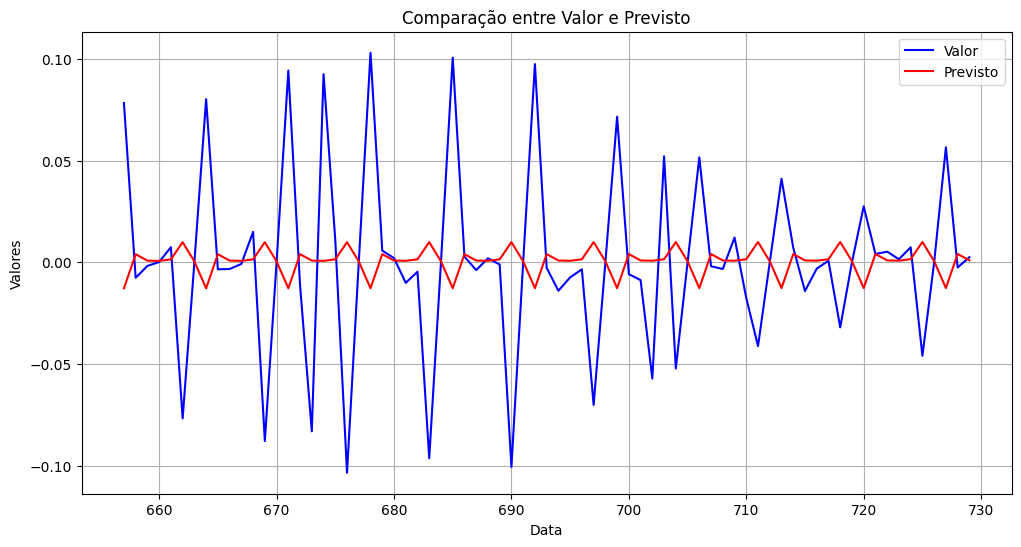

In [74]:
real['y_previsto'] = forecast_ph[['yhat']].tail(73)

# Plotar as duas séries temporais
plt.figure(figsize=(12, 6))
plt.plot(real.index, real['y'], label='Valor', color='blue')
plt.plot(real.index, real['y_previsto'], label='Previsto', color='red')
plt.title('Comparação entre Valor e Previsto')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)
plt.show()

In [75]:
# Calculo do WMAPE
precisao2_prophet = wmape(real['y'], real['y_previsto'])
print(f"WMAPE: {precisao2_prophet:.2%}")

# Calculo do R²
r22_prophet = r2_score(real['y'], real['y_previsto'])
print(f"R²: {r22_prophet:.2}")

WMAPE: 113.09%
R²: -0.26


### ARIMA com complementação

In [76]:
df2_dif

Valor
Data                
2022-06-28 -0.001718
2022-06-29 -0.009680
2022-06-30 -0.010900
2022-07-01  0.004172
2022-07-02  0.158108
...              ...
2024-06-22 -0.045842
2024-06-23  0.000000
2024-06-24  0.056466
2024-06-25 -0.002498
2024-06-26  0.002531

[730 rows x 1 columns]

In [77]:
numero = int(df2_dif.count()*0.1)
treino = df2_dif.head(len(df2_dif)-numero)
real = df2_dif.tail(numero)

treino.count(), real.count()

(Valor    657
 dtype: int64,
 Valor    73
 dtype: int64)

<Figure size 1000x600 with 0 Axes>

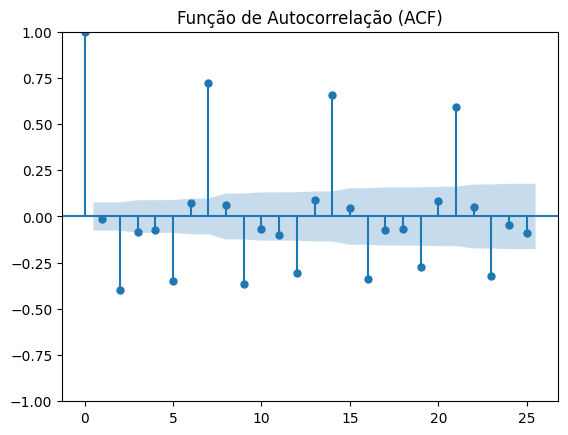

<Figure size 1000x600 with 0 Axes>

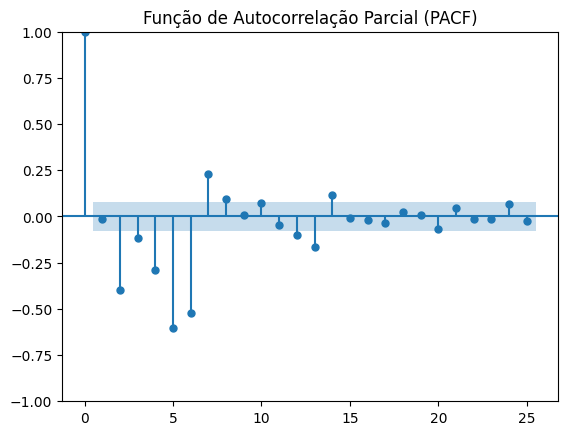

In [78]:
# Plot da Função de Autocorrelação (ACF)
plt.figure(figsize=(10, 6))
plot_acf(treino['Valor'], lags=25)
plt.title('Função de Autocorrelação (ACF)')
plt.show()

# Plot da Função de Autocorrelação Parcial (PACF)
plt.figure(figsize=(10, 6))
plot_pacf(treino['Valor'], lags=25)
plt.title('Função de Autocorrelação Parcial (PACF)')
plt.show()

In [80]:
# Criando a função do modelo
sm_ARIMA = ARIMA(treino['Valor'], order=(13, 1, 21))
# Treinando o modelo
sm_ARIMA_fit = sm_ARIMA.fit()

# Fazer previsões
forecast_steps = 73  # Número de pontos a serem previstos
forecast = sm_ARIMA_fit.forecast(steps=forecast_steps)
real['Previsto'] = forecast
real

c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Guilherme\AppData\Local\Temp\ipykernel_9480\2694042844.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real['Previsto'] = forecast


Valor  Previsto
Data                          
2024-04-15  0.078220  0.104387
2024-04-16 -0.007568  0.001475
2024-04-17 -0.001754 -0.007056
2024-04-18  0.000201 -0.003473
2024-04-19  0.007444 -0.019433
...              ...       ...
2024-06-22 -0.045842 -0.049482
2024-06-23  0.000000  0.001681
2024-06-24  0.056466  0.073719
2024-06-25 -0.002498  0.001735
2024-06-26  0.002531 -0.013920

[73 rows x 2 columns]

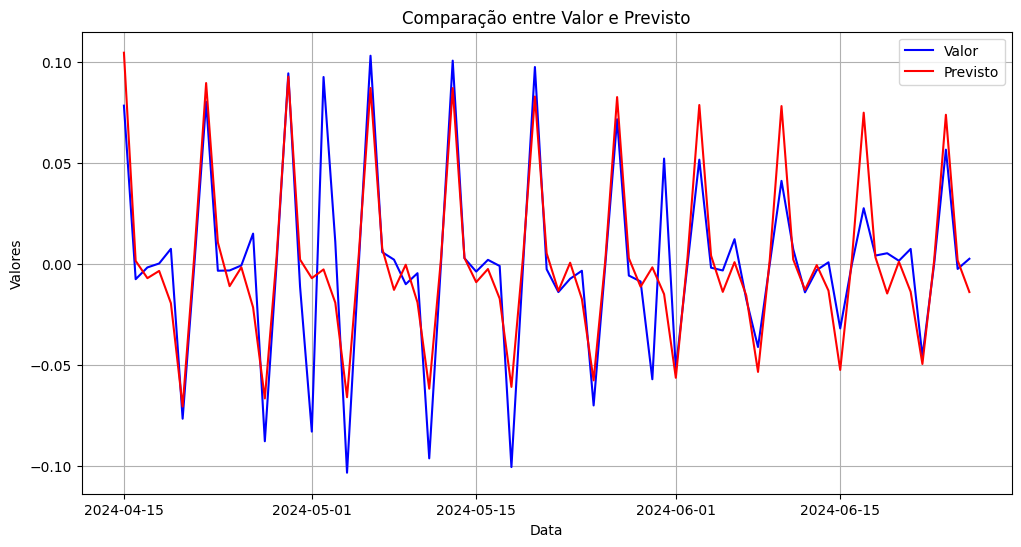

In [81]:
# Plotar as duas séries temporais
plt.figure(figsize=(12, 6))
plt.plot(real.index, real['Valor'], label='Valor', color='blue')
plt.plot(real.index, real['Previsto'], label='Previsto', color='red')
plt.title('Comparação entre Valor e Previsto')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)
plt.show()

In [82]:
# Calculo do WMAPE
precisao2_sm_ARIMA_c = wmape(real['Valor'], real['Previsto'])
print(f"WMAPE: {precisao2_sm_ARIMA_c:.2%}")

# Calculo do R²
r22_sm_ARIMA_c = r2_score(real['Valor'], real['Previsto'])
print(f"R²: {r22_sm_ARIMA_c:.2}")

WMAPE: 55.13%
R²: 0.72


### SARIMA com complementação

In [84]:
# Criando a função do modelo
sm_SARIMA = SARIMAX(treino['Valor'], order=(5, 1, 1),
                                     seasonal_order=(1,0,1,7),
                                     enforce_stationarity=False,
                                     enforce_invertibility=False)
# Treinando o modelo
sm_SARIMA_fit = sm_SARIMA.fit()

# Fazer previsões
forecast_steps = 73  # Número de pontos a serem previstos
forecast = sm_SARIMA_fit.forecast(steps=forecast_steps)
real['Previsto'] = forecast
real

c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Guilherme\AppData\Local\Temp\ipykernel_9480\3803807851.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real['Previsto'] = forecast


Valor  Previsto
Data                          
2024-04-15  0.078220  0.093859
2024-04-16 -0.007568  0.005899
2024-04-17 -0.001754 -0.006606
2024-04-18  0.000201  0.000112
2024-04-19  0.007444 -0.020975
...              ...       ...
2024-06-22 -0.045842 -0.029994
2024-06-23  0.000000  0.000630
2024-06-24  0.056466  0.038522
2024-06-25 -0.002498  0.002317
2024-06-26  0.002531 -0.001979

[73 rows x 2 columns]

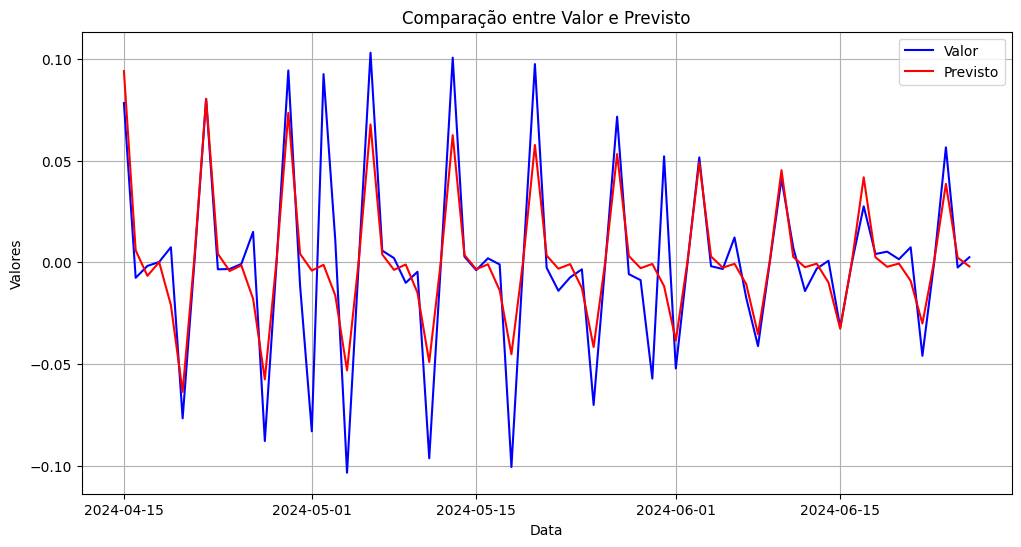

In [85]:
# Plotar as duas séries temporais
plt.figure(figsize=(12, 6))
plt.plot(real.index, real['Valor'], label='Valor', color='blue')
plt.plot(real.index, real['Previsto'], label='Previsto', color='red')
plt.title('Comparação entre Valor e Previsto')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)
plt.show()

In [86]:
# Calculo do WMAPE
precisao2_sm_SARIMA_c = wmape(real['Valor'], real['Previsto'])
print(f"WMAPE: {precisao2_sm_SARIMA_c:.2%}")

# Calculo do R²
r22_sm_SARIMA_c = r2_score(real['Valor'], real['Previsto'])
print(f"R²: {r22_sm_SARIMA_c:.2}")

WMAPE: 53.92%
R²: 0.7


### ARIMA sem complementação

In [87]:
df2_s = df2.reset_index(drop=True)
df2_s = np.log(df2_s)
df2_s = df2_s.diff(1)
df2_s = df2_s.dropna()
df2_s

Valor
1   -0.001718
2   -0.009680
3   -0.010900
4    0.004172
5   -0.003493
..        ...
495  0.001537
496  0.007403
497  0.010624
498 -0.002498
499  0.002531

[499 rows x 1 columns]

In [88]:
numero = int(df2_s.count()*0.1)
treino = df2_s.head(len(df2_s)-numero)
real = df2_s.tail(numero)

treino.count(), real.count()

(Valor    450
 dtype: int64,
 Valor    49
 dtype: int64)

<Figure size 1000x600 with 0 Axes>

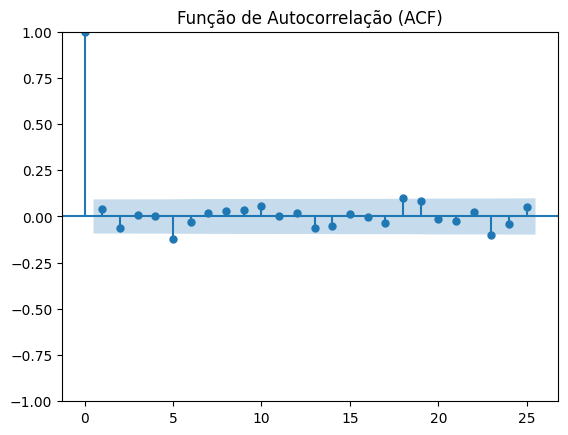

<Figure size 1000x600 with 0 Axes>

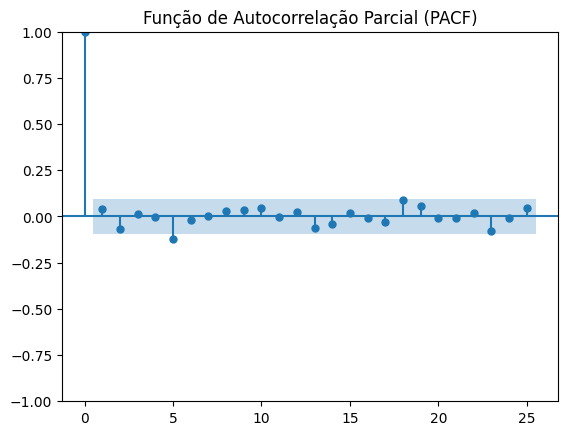

In [89]:
# Plot da Função de Autocorrelação (ACF)
plt.figure(figsize=(10, 6))
plot_acf(treino['Valor'], lags=25)
plt.title('Função de Autocorrelação (ACF)')
plt.show()

# Plot da Função de Autocorrelação Parcial (PACF)
plt.figure(figsize=(10, 6))
plot_pacf(treino['Valor'], lags=25)
plt.title('Função de Autocorrelação Parcial (PACF)')
plt.show()

In [91]:
# Criando a função do modelo
sm_ARIMA = ARIMA(treino['Valor'], order=(5, 1, 5))
# Treinando o modelo
sm_ARIMA_fit = sm_ARIMA.fit()

# Fazer previsões
forecast_steps = 73  # Número de pontos a serem previstos
forecast = sm_ARIMA_fit.forecast(steps=forecast_steps)
real['Previsto'] = forecast


c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Guilherme\AppDa

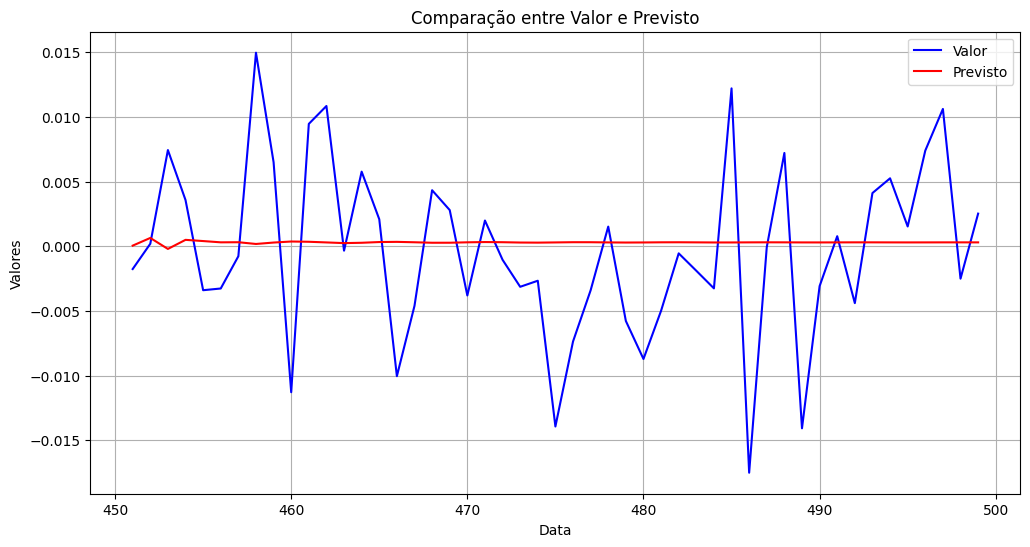

In [92]:
# Plotar as duas séries temporais
plt.figure(figsize=(12, 6))
plt.plot(real.index, real['Valor'], label='Valor', color='blue')
plt.plot(real.index, real['Previsto'], label='Previsto', color='red')
plt.title('Comparação entre Valor e Previsto')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)
plt.show()

In [93]:
# Calculo do WMAPE
precisao2_sm_ARIMA_s = wmape(real['Valor'], real['Previsto'])
print(f"WMAPE: {precisao2_sm_ARIMA_s:.2%}")

# Calculo do R²
r22_sm_ARIMA_s = r2_score(real['Valor'], real['Previsto'])
print(f"R²: {r22_sm_ARIMA_s:.2}")

WMAPE: 100.95%
R²: -0.013


### SARIMA sem complementação

In [95]:
# Criando a função do modelo
sm_SARIMA = SARIMAX(treino['Valor'], order=(5, 1, 5),
                                     seasonal_order=(2,1,2,7),
                                     enforce_stationarity=False,
                                     enforce_invertibility=False)
# Treinando o modelo
sm_SARIMA_fit = sm_SARIMA.fit()

# Fazer previsões
forecast_steps = 73  # Número de pontos a serem previstos
forecast = sm_SARIMA_fit.forecast(steps=forecast_steps)
real['Previsto'] = forecast


c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction

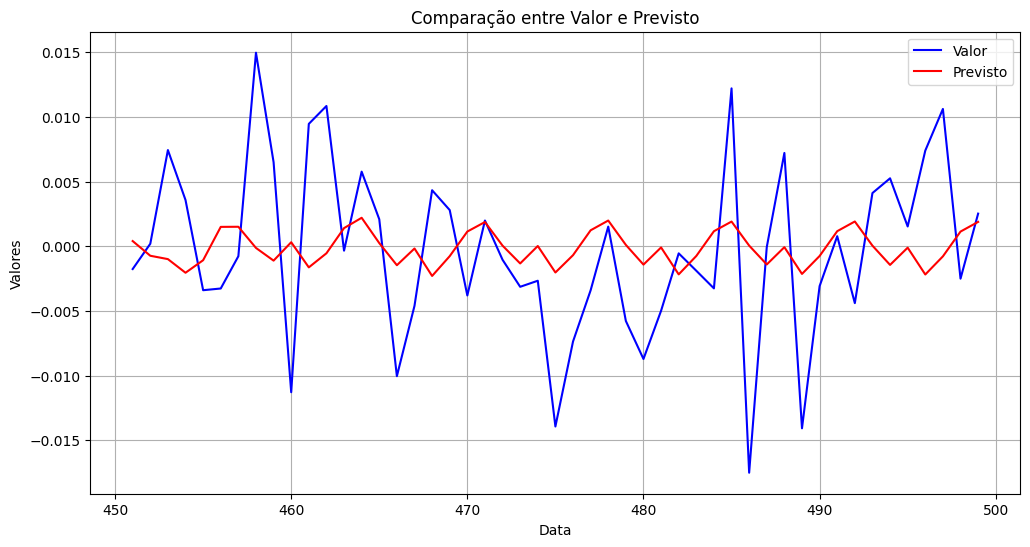

In [96]:
# Plotar as duas séries temporais
plt.figure(figsize=(12, 6))
plt.plot(real.index, real['Valor'], label='Valor', color='blue')
plt.plot(real.index, real['Previsto'], label='Previsto', color='red')
plt.title('Comparação entre Valor e Previsto')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)
plt.show()

In [97]:
# Calculo do WMAPE
precisao2_sm_SARIMA_s = wmape(real['Valor'], real['Previsto'])
print(f"WMAPE: {precisao2_sm_SARIMA_s:.2%}")

# Calculo do R²
r22_sm_SARIMA_s = r2_score(real['Valor'], real['Previsto'])
print(f"R²: {r22_sm_SARIMA_s:.2}")

WMAPE: 102.93%
R²: -0.014


In [98]:
print('RESUMO DOS MODELOS:')
print(f'Modelo AutoARIMA:\n WMAPE: {precisao2_AA:.2%} \n R²: {r22_AA:.2} \n')
print(f'Modelo ARIMA sem complementação:\n WMAPE: {precisao2_sm_ARIMA_s:.2%} \n R²: {r22_sm_ARIMA_s:.2} \n')
print(f'Modelo ARIMA com complementação:\n WMAPE: {precisao2_sm_ARIMA_c:.2%} \n R²: {r22_sm_ARIMA_c:.2} \n')
print(f'Modelo SARIMA sem complementação:\n WMAPE: {precisao2_sm_SARIMA_s:.2%} \n R²: {r22_sm_SARIMA_s:.2} \n')
print(f'Modelo SARIMA com complementação:\n WMAPE: {precisao2_sm_SARIMA_c:.2%} \n R²: {r22_sm_SARIMA_c:.2} \n')
print(f'Modelo Prophet:\n WMAPE: {precisao2_prophet:.2%} \n R²: {r22_prophet:.2} \n')

RESUMO DOS MODELOS:
Modelo AutoARIMA:
 WMAPE: 47.83% 
 R²: 0.75 

Modelo ARIMA sem complementação:
 WMAPE: 100.95% 
 R²: -0.013 

Modelo ARIMA com complementação:
 WMAPE: 55.13% 
 R²: 0.72 

Modelo SARIMA sem complementação:
 WMAPE: 102.93% 
 R²: -0.014 

Modelo SARIMA com complementação:
 WMAPE: 53.92% 
 R²: 0.7 

Modelo Prophet:
 WMAPE: 113.09% 
 R²: -0.26 



Com a adição de 1 ano nos dados, os modelos AutoARIMA, ARIMA com complementação e SARIMA com complementação apresentaram uma grande melhora, enquanto os outros modelos continuaram não se adequando corretamente. O próximo passo será adicionar mais um ano de dados na série temporal para ver se os modelos continuarão melhorando

## Utilizando dados referentes a 3 anos

In [99]:
df3 = pd.read_csv('Ibovespa 3.csv')
df3

Data   Último  Abertura   Máxima   Mínima    Vol.    Var%
0    26.06.2024  122.641   122.331  122.701  121.402   8,18B   0,25%
1    25.06.2024  122.331   122.634  122.849  121.997   6,94M  -0,25%
2    24.06.2024  122.637   121.343  122.840  121.307   7,84M   1,07%
3    21.06.2024  121.341   120.446  121.580  120.061  12,91M   0,74%
4    20.06.2024  120.446   120.267  121.607  120.156   8,66M   0,15%
..          ...      ...       ...      ...      ...     ...     ...
743  02.07.2021  127.622   125.667  127.672  125.667   7,43M   1,56%
744  01.07.2021  125.666   126.802  127.204  124.994   9,29M  -0,90%
745  30.06.2021  126.802   127.323  127.323  126.199   9,10M  -0,41%
746  29.06.2021  127.327   127.429  127.507  126.184   7,78M  -0,08%
747  28.06.2021  127.429   127.255  128.067  126.629   8,16M   0,14%

[748 rows x 7 columns]

In [100]:
# Criando novo DataFrame
df3 = df3[['Data','Último']]

# Renomeando a segunda coluna para facilitar os próximos passos
df3.rename(columns={'Último':'Valor'}, inplace=True)

# Substituindo '.' por '-' na coluna 'Data'
df3['Data'] = df3['Data'].str.replace('.', '-')

# Convertendo a coluna 'Data' para datetime e definindo como índice
df3.index = pd.to_datetime(df3['Data'], format="%d-%m-%Y")

# Removendo a coluna 'Data'
df3.drop("Data", inplace=True, axis=1)

# Ordenando o DataFrame por índice em ordem ascendente
df3.sort_index(ascending=True, inplace=True)


df3

C:\Users\Guilherme\AppData\Local\Temp\ipykernel_9480\2771199041.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.rename(columns={'Último':'Valor'}, inplace=True)
C:\Users\Guilherme\AppData\Local\Temp\ipykernel_9480\2771199041.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df3['Data'] = df3['Data'].str.replace('.', '-')
C:\Users\Guilherme\AppData\Local\Temp\ipykernel_9480\2771199041.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Valor
Data               
2021-06-28  127.429
2021-06-29  127.327
2021-06-30  126.802
2021-07-01  125.666
2021-07-02  127.622
...             ...
2024-06-20  120.446
2024-06-21  121.341
2024-06-24  122.637
2024-06-25  122.331
2024-06-26  122.641

[748 rows x 1 columns]

In [101]:
# Indicando que a frequência do DataFrame é por dia
df3 = df3.asfreq('D')

# Printar o DataFrame antes da tranformação
print(df3.tail(10),'\n\n')

df3_media = df3.mean()
df3 = df3.fillna(df3_media)

print(df3.tail(10),'\n\n')

              Valor
Data               
2024-06-17  119.138
2024-06-18  119.630
2024-06-19  120.261
2024-06-20  120.446
2024-06-21  121.341
2024-06-22      NaN
2024-06-23      NaN
2024-06-24  122.637
2024-06-25  122.331
2024-06-26  122.641 


                 Valor
Data                  
2024-06-17  119.138000
2024-06-18  119.630000
2024-06-19  120.261000
2024-06-20  120.446000
2024-06-21  121.341000
2024-06-22  114.686575
2024-06-23  114.686575
2024-06-24  122.637000
2024-06-25  122.331000
2024-06-26  122.641000 




In [102]:
df3_log = np.log(df3)
df3_log

Valor
Data                
2021-06-28  4.847559
2021-06-29  4.846759
2021-06-30  4.842627
2021-07-01  4.833628
2021-07-02  4.849073
...              ...
2024-06-22  4.742203
2024-06-23  4.742203
2024-06-24  4.809229
2024-06-25  4.806730
2024-06-26  4.809261

[1095 rows x 1 columns]

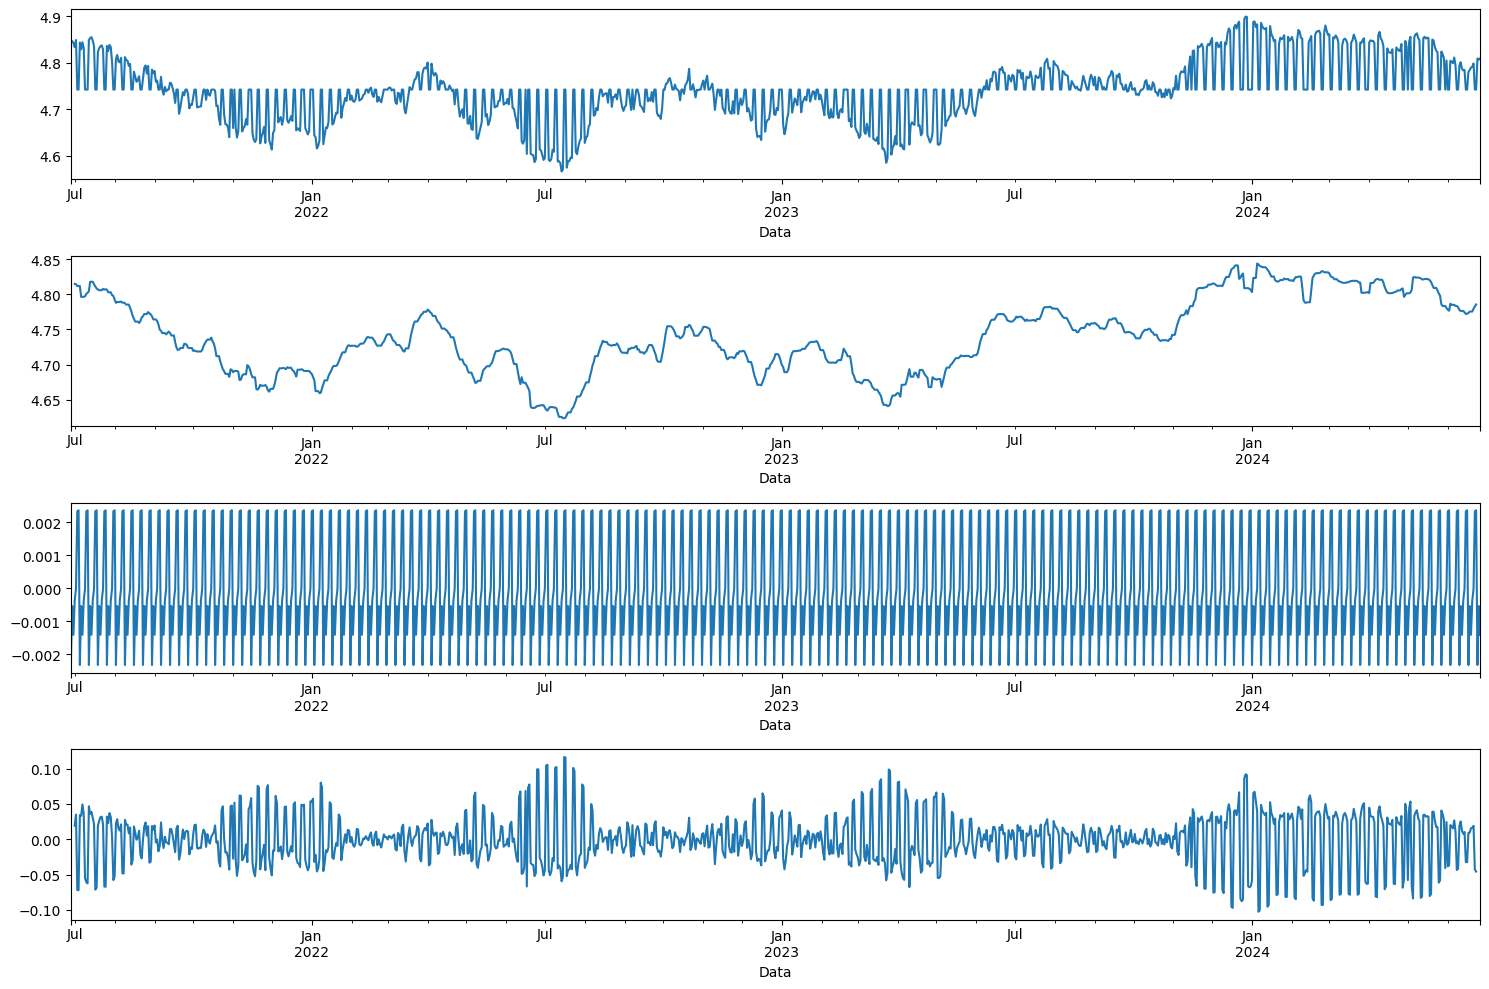

In [103]:
# Decomposição da série temporal
decompose = seasonal_decompose(df3_log)

# Plotagem 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

# Plot da série comum
decompose.observed.plot(ax=ax1)
# Plot da tendência
decompose.trend.plot(ax=ax2)
# Plot da sazonalidade
decompose.seasonal.plot(ax=ax3)
#Plot dos ruídos
decompose.resid.plot(ax=ax4)

plt.tight_layout()

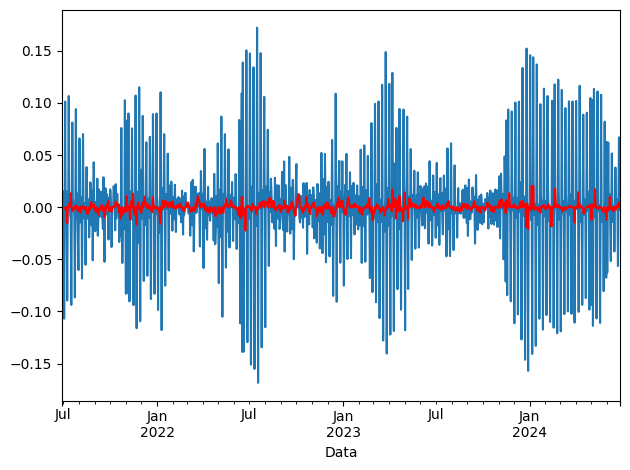

In [104]:
# Derivar a Série Temporal
df3_dif = df3_log.diff(1)
df3_dif = df3_dif.dropna()
ma3_dif = df3_dif.rolling(7).mean()

# Nova Plotagem
f, ax = plt.subplots()
df3_dif.plot(ax=ax, legend=False)
ma3_dif.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

In [105]:
estacionaridade = adfuller(df3_dif)

print("Teste ADF")
print(f"Teste Estatístico: {estacionaridade[0]}")
print(f"P-Value: {estacionaridade[1]}")
print("Valores críticos:")

for key, value in estacionaridade[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -7.873705762733337
P-Value: 4.9075296687183545e-12
Valores críticos:
	1%: -3.436459052172655
	5%: -2.864237372528562
	10%: -2.568206176974609


### AutoARIMA

In [106]:
df3_forecast = df3_dif.reset_index()
df3_forecast.rename(columns={'Data':'ds','Valor':'y'}, inplace=True)
df3_forecast['unique_id'] = 'Ibovespa'
df3_forecast = df3_forecast[['unique_id','ds','y']]
df3_forecast

unique_id         ds         y
0     Ibovespa 2021-06-29 -0.000801
1     Ibovespa 2021-06-30 -0.004132
2     Ibovespa 2021-07-01 -0.008999
3     Ibovespa 2021-07-02  0.015445
4     Ibovespa 2021-07-03 -0.106870
...        ...        ...       ...
1089  Ibovespa 2024-06-22 -0.056402
1090  Ibovespa 2024-06-23  0.000000
1091  Ibovespa 2024-06-24  0.067026
1092  Ibovespa 2024-06-25 -0.002498
1093  Ibovespa 2024-06-26  0.002531

[1094 rows x 3 columns]

In [107]:
treino = df3_forecast[df3_forecast['ds'] < '2024-04-15']
real = df3_forecast[df3_forecast['ds'] >= '2024-04-15']
h = real['ds'].nunique()
h

73

WMAPE: 47.83%
R²: 0.72


c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


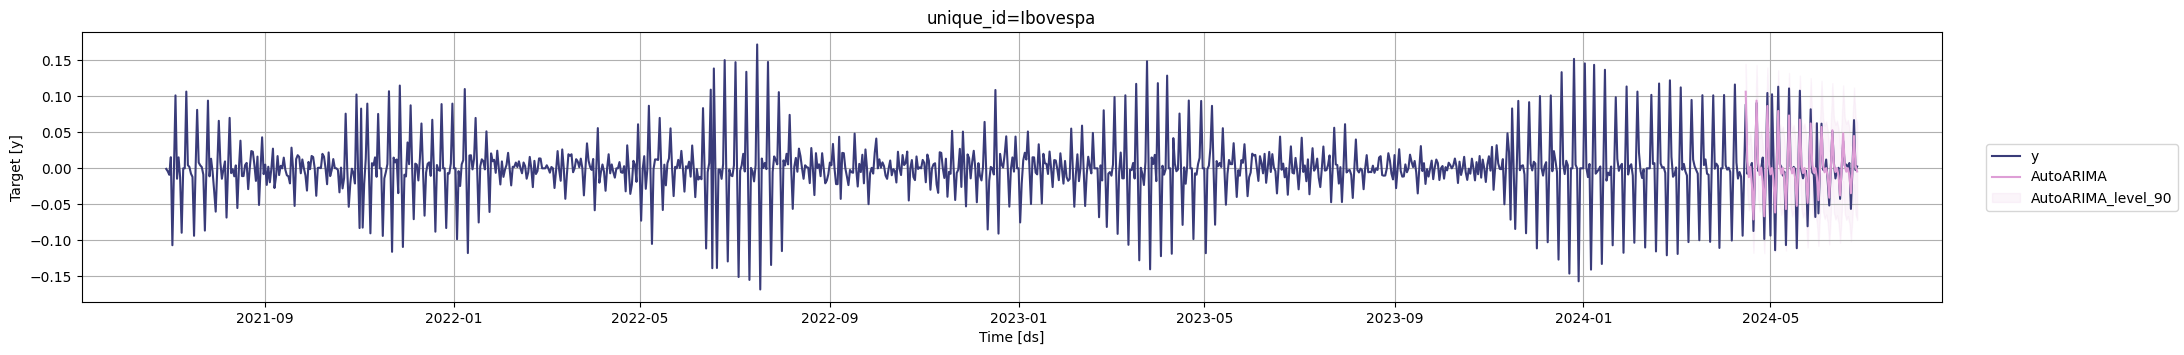

In [108]:
sf_AA = StatsForecast(models=[AutoARIMA(season_length=7, stationary=True)], freq='D', n_jobs=-1)
sf_AA.fit(treino)

previsao3_AA = sf_AA.predict(h=h, level=[90])
previsao3_AA = previsao3_AA.reset_index().merge(real, on=['ds', 'unique_id'], how='left')

precisao3_AA = wmape(previsao3_AA['y'].values, previsao3_AA['AutoARIMA'].values)
print(f"WMAPE: {precisao2_AA:.2%}")

r23_AA = r2_score(previsao3_AA['y'], previsao3_AA['AutoARIMA'])
print(f"R²: {r23_AA:.2}")

sf_AA.plot(treino, previsao3_AA, level=[90], unique_ids=['Ibovespa'],engine ='matplotlib')

### ARIMA

In [109]:
treino = df3_dif[df3_dif.index < '2024-04-15']
real = df3_dif[df3_dif.index >= '2024-04-15']

<Figure size 1000x600 with 0 Axes>

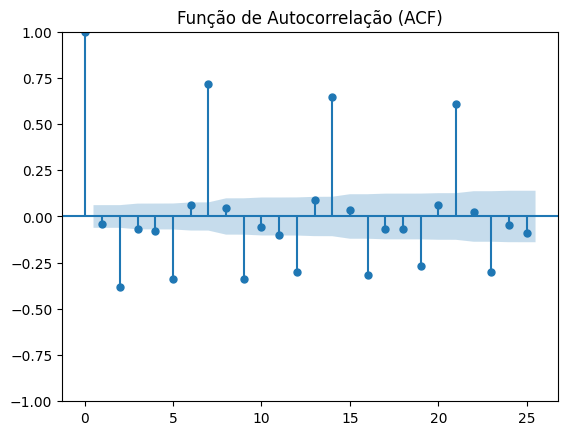

<Figure size 1000x600 with 0 Axes>

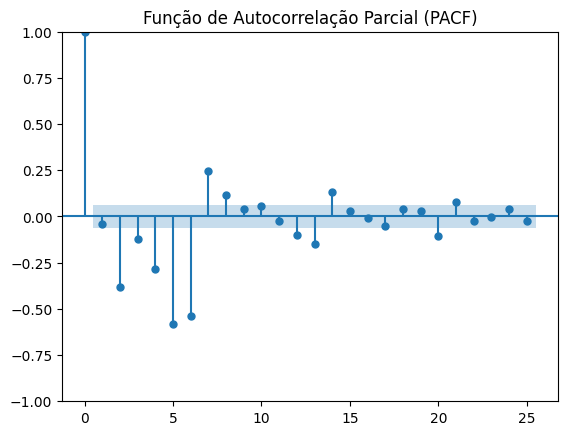

In [110]:
# Plot da Função de Autocorrelação (ACF)
plt.figure(figsize=(10, 6))
plot_acf(treino['Valor'], lags=25)
plt.title('Função de Autocorrelação (ACF)')
plt.show()

# Plot da Função de Autocorrelação Parcial (PACF)
plt.figure(figsize=(10, 6))
plot_pacf(treino['Valor'], lags=25)
plt.title('Função de Autocorrelação Parcial (PACF)')
plt.show()

In [112]:
# Criando a função do modelo
sm_ARIMA = ARIMA(treino['Valor'], order=(21, 1, 20))
# Treinando o modelo
sm_ARIMA_fit = sm_ARIMA.fit()

# Fazer previsões
forecast_steps = 73  # Número de pontos a serem previstos
forecast = sm_ARIMA_fit.forecast(steps=forecast_steps)
real['Previsto'] = forecast
real

c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Guilherme\AppData\Local\Temp\ipykernel_9480\3171495858.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

Valor  Previsto
Data                          
2024-04-15  0.088779  0.106143
2024-04-16 -0.007568  0.000255
2024-04-17 -0.001754 -0.005629
2024-04-18  0.000201  0.006528
2024-04-19  0.007444 -0.035438
...              ...       ...
2024-06-22 -0.056402 -0.019062
2024-06-23  0.000000  0.004838
2024-06-24  0.067026  0.034114
2024-06-25 -0.002498  0.012982
2024-06-26  0.002531 -0.015397

[73 rows x 2 columns]

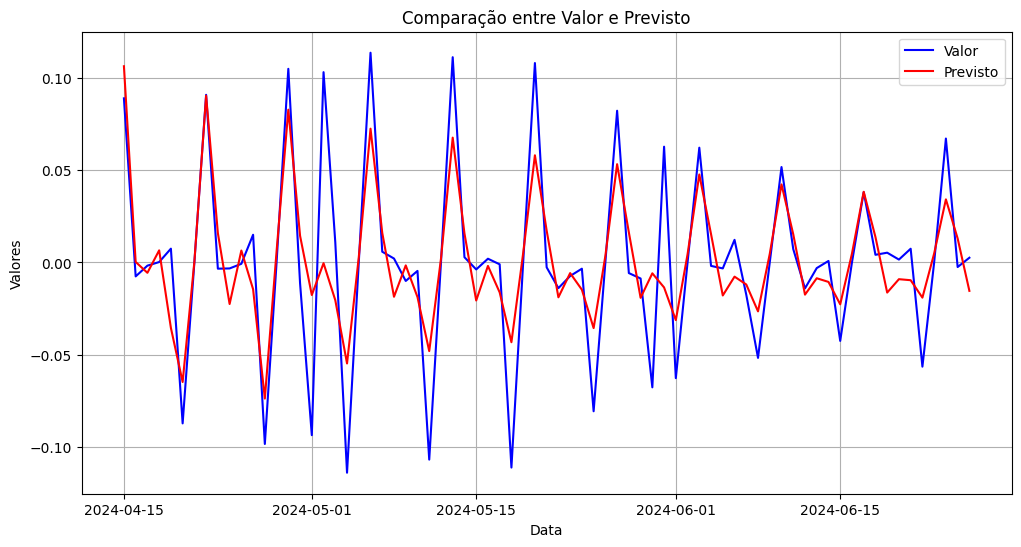

In [113]:
# Plotar as duas séries temporais
plt.figure(figsize=(12, 6))
plt.plot(real.index, real['Valor'], label='Valor', color='blue')
plt.plot(real.index, real['Previsto'], label='Previsto', color='red')
plt.title('Comparação entre Valor e Previsto')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)
plt.show()

In [114]:
# Calculo do WMAPE
precisao3_sm_ARIMA_c = wmape(real['Valor'], real['Previsto'])
print(f"WMAPE: {precisao3_sm_ARIMA_c:.2%}")

# Calculo do R²
r23_sm_ARIMA_c = r2_score(real['Valor'], real['Previsto'])
print(f"R²: {r23_sm_ARIMA_c:.2}")

WMAPE: 68.19%
R²: 0.65


### SARIMA

In [116]:
# Criando a função do modelo
sm_SARIMA = SARIMAX(treino['Valor'], order=(5, 1, 5),
                                     seasonal_order=(1,0,2,7),
                                     enforce_stationarity=False,
                                     enforce_invertibility=False)
# Treinando o modelo
sm_SARIMA_fit = sm_SARIMA.fit()

# Fazer previsões
forecast_steps = 73  # Número de pontos a serem previstos
forecast = sm_SARIMA_fit.forecast(steps=forecast_steps)
real['Previsto'] = forecast
real

c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Guilherme\AppData\Local\Temp\ipykernel_9480\3812897519.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real['Previsto'] = forecast


Valor  Previsto
Data                          
2024-04-15  0.088779  0.107651
2024-04-16 -0.007568  0.005675
2024-04-17 -0.001754 -0.010240
2024-04-18  0.000201  0.002612
2024-04-19  0.007444 -0.019918
...              ...       ...
2024-06-22 -0.056402 -0.037003
2024-06-23  0.000000  0.000373
2024-06-24  0.067026  0.046946
2024-06-25 -0.002498  0.002031
2024-06-26  0.002531 -0.003651

[73 rows x 2 columns]

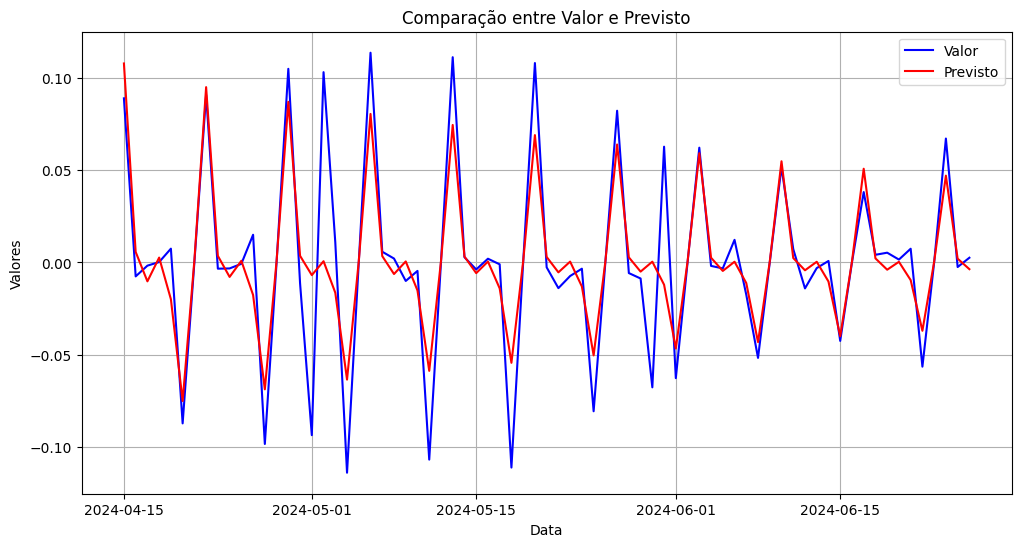

In [117]:
# Plotar as duas séries temporais
plt.figure(figsize=(12, 6))
plt.plot(real.index, real['Valor'], label='Valor', color='blue')
plt.plot(real.index, real['Previsto'], label='Previsto', color='red')
plt.title('Comparação entre Valor e Previsto')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)
plt.show()

In [118]:
# Calculo do WMAPE
precisao3_sm_SARIMA_c = wmape(real['Valor'], real['Previsto'])
print(f"WMAPE: {precisao3_sm_SARIMA_c:.2%}")

# Calculo do R²
r23_sm_SARIMA_c = r2_score(real['Valor'], real['Previsto'])
print(f"R²: {r23_sm_SARIMA_c:.2}")

WMAPE: 50.27%
R²: 0.73


In [119]:
print('RESUMO DOS MODELOS:')
print(f'Modelo AutoARIMA:\n WMAPE: {precisao3_AA:.2%} \n R²: {r23_AA:.2} \n')
print(f'Modelo ARIMA:\n WMAPE: {precisao3_sm_ARIMA_c:.2%} \n R²: {r23_sm_ARIMA_c:.2} \n')
print(f'Modelo SARIMA:\n WMAPE: {precisao3_sm_SARIMA_c:.2%} \n R²: {r23_sm_SARIMA_c:.2} \n')

RESUMO DOS MODELOS:
Modelo AutoARIMA:
 WMAPE: 52.63% 
 R²: 0.72 

Modelo ARIMA:
 WMAPE: 68.19% 
 R²: 0.65 

Modelo SARIMA:
 WMAPE: 50.27% 
 R²: 0.73 



Com dados de 3 anos os modelos não apresentaram melhora, então agora a tentativa é diminuir a quantidade de dias de previsão.

Como a Ibovespa só funciona em dia útil, vamos limitar a previsão para um período de sazonalidade, no caso 5 dias.

### AutoARIMA

In [157]:
treino = df3_forecast[df3_forecast['ds']<='2024-06-21']
real = df3_forecast[df3_forecast['ds']>'2024-06-21']
h = real['ds'].nunique()
h

5

WMAPE: 29.29%
R²: 0.92


c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


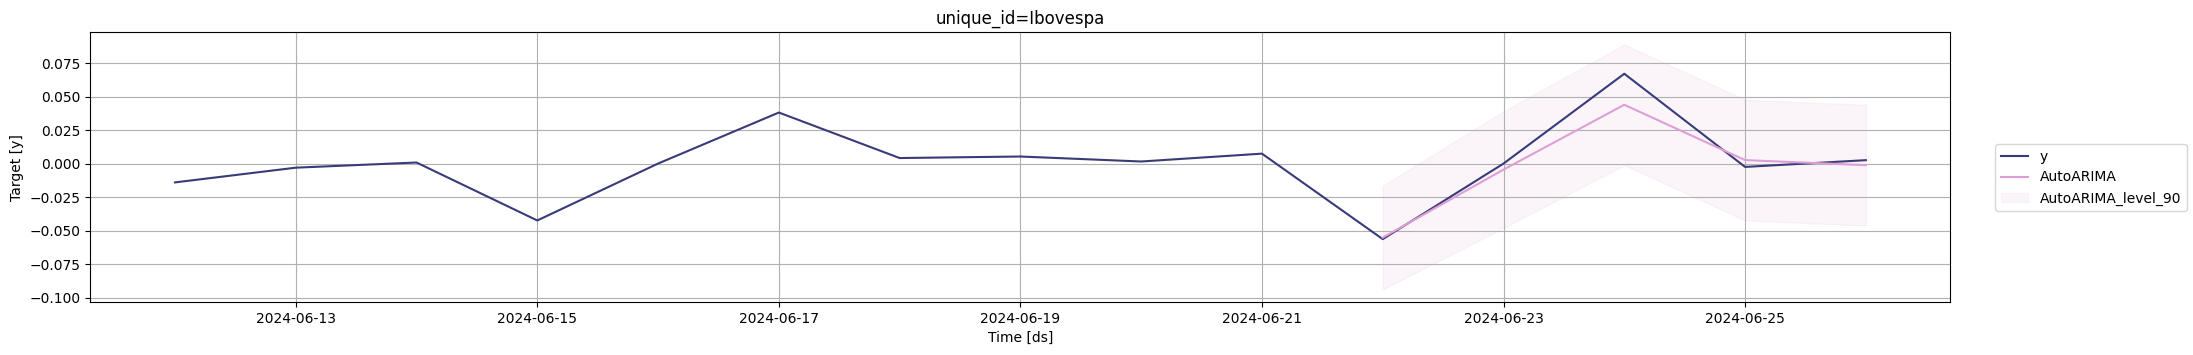

In [158]:
sf_AA = StatsForecast(models=[AutoARIMA(season_length=7, stationary=True,seasonal=True)], freq='D', n_jobs=-1)
sf_AA.fit(treino)

previsao4_AA = sf_AA.predict(h=h, level=[90])
previsao4_AA = previsao4_AA.reset_index().merge(real, on=['ds', 'unique_id'], how='left')

precisao4_AA = wmape(previsao4_AA['y'].values, previsao4_AA['AutoARIMA'].values)
print(f"WMAPE: {precisao4_AA:.2%}")

r24_AA = r2_score(previsao4_AA['y'], previsao4_AA['AutoARIMA'])
print(f"R²: {r24_AA:.2}")

sf_AA.plot(treino, previsao4_AA, level=[90], unique_ids=['Ibovespa'],engine ='matplotlib', max_insample_length=10)

### ARIMA

In [159]:
treino = df3_dif[df3_dif.index<='2024-06-21']
real = df3_dif[df3_dif.index>'2024-06-21']


In [140]:
# Criando a função do modelo
sm_ARIMA = ARIMA(treino['Valor'], order=(13, 1, 21))
# Treinando o modelo
sm_ARIMA_fit = sm_ARIMA.fit()

# Fazer previsões
forecast_steps = 5  # Número de pontos a serem previstos
forecast = sm_ARIMA_fit.forecast(steps=forecast_steps)
real['Previsto'] = forecast
real

c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Guilherme\AppData\Local\Temp\ipykernel_9480\2352828821.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real['Previsto'] = forecast


Valor  Previsto
Data                          
2024-06-22 -0.056402 -0.052745
2024-06-23  0.000000 -0.006009
2024-06-24  0.067026  0.048407
2024-06-25 -0.002498 -0.002709
2024-06-26  0.002531 -0.001313

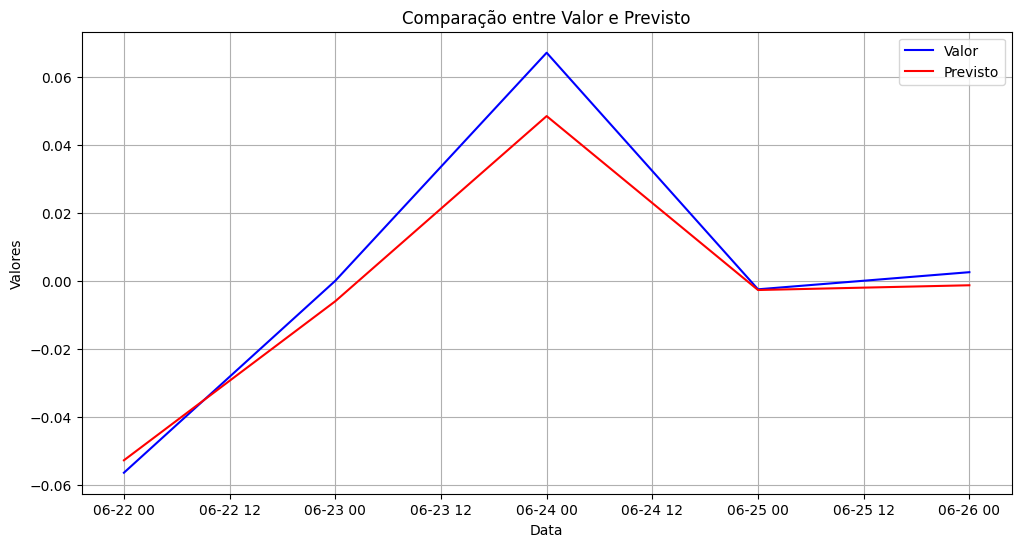

In [141]:
# Plotar as duas séries temporais
plt.figure(figsize=(12, 6))
plt.plot(real.index, real['Valor'], label='Valor', color='blue')
plt.plot(real.index, real['Previsto'], label='Previsto', color='red')
plt.title('Comparação entre Valor e Previsto')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)
plt.show()

In [142]:
# Calculo do WMAPE
precisao4_sm_ARIMA_c = wmape(real['Valor'], real['Previsto'])
print(f"WMAPE: {precisao4_sm_ARIMA_c:.2%}")

# Calculo do R²
r24_sm_ARIMA_c = r2_score(real['Valor'], real['Previsto'])
print(f"R²: {r24_sm_ARIMA_c:.2}")

WMAPE: 25.17%
R²: 0.95


### SARIMA

In [152]:
# Criando a função do modelo
sm_SARIMA = SARIMAX(treino['Valor'], order=(5, 1, 5),
                                     seasonal_order=(1,0,1,7),
                                     enforce_stationarity=False,
                                     enforce_invertibility=False)
# Treinando o modelo
sm_SARIMA_fit = sm_SARIMA.fit()

# Fazer previsões
forecast_steps = 5  # Número de pontos a serem previstos
forecast = sm_SARIMA_fit.forecast(steps=forecast_steps)
real['Previsto'] = forecast
real

c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Guilherme\AppData\Local\Temp\ipykernel_9480\1772910951.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real['Previsto'] = forecast


Valor  Previsto
Data                          
2024-06-22 -0.056402 -0.055402
2024-06-23  0.000000 -0.005726
2024-06-24  0.067026  0.044812
2024-06-25 -0.002498  0.004472
2024-06-26  0.002531 -0.000435

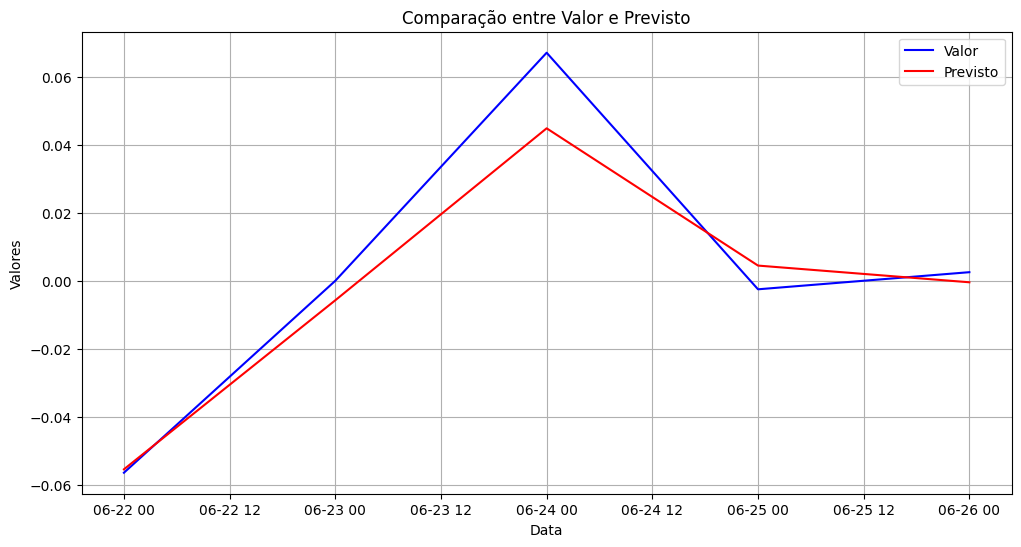

In [153]:
# Plotar as duas séries temporais
plt.figure(figsize=(12, 6))
plt.plot(real.index, real['Valor'], label='Valor', color='blue')
plt.plot(real.index, real['Previsto'], label='Previsto', color='red')
plt.title('Comparação entre Valor e Previsto')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)
plt.show()

In [154]:
# Calculo do WMAPE
precisao4_sm_SARIMA_c = wmape(real['Valor'], real['Previsto'])
print(f"WMAPE: {precisao4_sm_SARIMA_c:.2%}")

# Calculo do R²
r24_sm_SARIMA_c = r2_score(real['Valor'], real['Previsto'])
print(f"R²: {r24_sm_SARIMA_c:.2}")

WMAPE: 30.26%
R²: 0.92


In [155]:
print('RESUMO DOS MODELOS:')
print(f'Modelo AutoARIMA:\n WMAPE: {precisao4_AA:.2%} \n R²: {r24_AA:.2} \n')
print(f'Modelo ARIMA com complementação:\n WMAPE: {precisao4_sm_ARIMA_c:.2%} \n R²: {r24_sm_ARIMA_c:.2} \n')
print(f'Modelo SARIMA com complementação:\n WMAPE: {precisao4_sm_SARIMA_c:.2%} \n R²: {r24_sm_SARIMA_c:.2} \n')

RESUMO DOS MODELOS:
Modelo AutoARIMA:
 WMAPE: 29.29% 
 R²: 0.92 

Modelo ARIMA com complementação:
 WMAPE: 25.17% 
 R²: 0.95 

Modelo SARIMA com complementação:
 WMAPE: 30.26% 
 R²: 0.92 



Os modelos apresentaram grande melhora com essa mudança, com o melhor resultado sendo do modelo ARIMA da biblioteca StatsModels, com um erro de aproximadamente 25% e com um R² de 0.95

# Conclusão

Dentre os teste realizados neste estudo, o que apresentou o melhor resultado foi utilizar a função ARIMA do StatsModels, utilizando dados referentes a 3 anos, completando o DataSet, nos dias referentes aos finais de semana, com a média geral dos dados e realizando uma previsão dos próximos 5 dias.

O modelo apresentou um erro de 25.17% utilizando a métrica WMAPE, e um valor R² de 0.95, mostrando que o modelo se adequou a variabilidade dos dados

Contudo, devido a certa imprevisibilidade decorrente no crescimento da Ibovespa, talvez se torne necessário a mudança de parâmetros referentes a autoregressão e a média móvel do modelo de acordo com o intervalo de dados presente na série temporal. Por isso, para esse estudo, o mais indicado seria utilizar a função AutoARIMA da biblioteca StatsForecast, que apresentou os valores 29.29% para a métrica WMAPE e um R² de valor 0.92. Essa função apresentou uma acurácia menor, porém, ainda está acima do mínimo requisitado e ela automatiza a busca pelos parâmetros que mais se adequam ao intervalo de predição.